# Plot Tour Length vs Radius and Number of Passengers

## Global Calls

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.optimize import curve_fit

In [32]:
# Read the CSV data
df = pd.read_csv('trip_data_campus_full.csv')
df = df.dropna(subset=['Tour_Length'])
print(df.head())

                 Park_and_Ride_Station  Passengers  Radius  Tour_Length
0  Fish Creek - Lacombe CTrain Station           4       2     8644.316
1  Fish Creek - Lacombe CTrain Station           4       2     8790.838
2  Fish Creek - Lacombe CTrain Station           4       2    10323.515
3  Fish Creek - Lacombe CTrain Station           4       3     9205.104
4  Fish Creek - Lacombe CTrain Station           4       3    13306.332


## Splitting Data by Station

In [33]:
stations = df['Park_and_Ride_Station'].unique()

# Will store them in a dictionary
station_dfs = {station: df[df['Park_and_Ride_Station'] == station] for station in stations}
print(stations)

fishcreek_df = station_dfs["Fish Creek - Lacombe CTrain Station"]
somerset_df = station_dfs["Somerset-Bridlewood"]
crowfoot_df = station_dfs["Crowfoot - North and South"]
tuscany_df = station_dfs["Tuscany Station - Rocky Ridge Terminal"]
saddletown_df = station_dfs["Saddletowne CTrain Park and Ride"]
sirocco_df = station_dfs["Sirocco Station"]
mall_df = station_dfs["Marlborough Mall"]
north_df = station_dfs["North Pointe"]


['Fish Creek - Lacombe CTrain Station' 'Somerset-Bridlewood'
 'Crowfoot - North and South' 'Tuscany Station - Rocky Ridge Terminal'
 'Saddletowne CTrain Park and Ride' 'Sirocco Station' 'Marlborough Mall'
 'North Pointe']


### Fishcreek

In [4]:
station = "Fish Creek - Lacombe CTrain Station"
station_df = station_dfs[station]

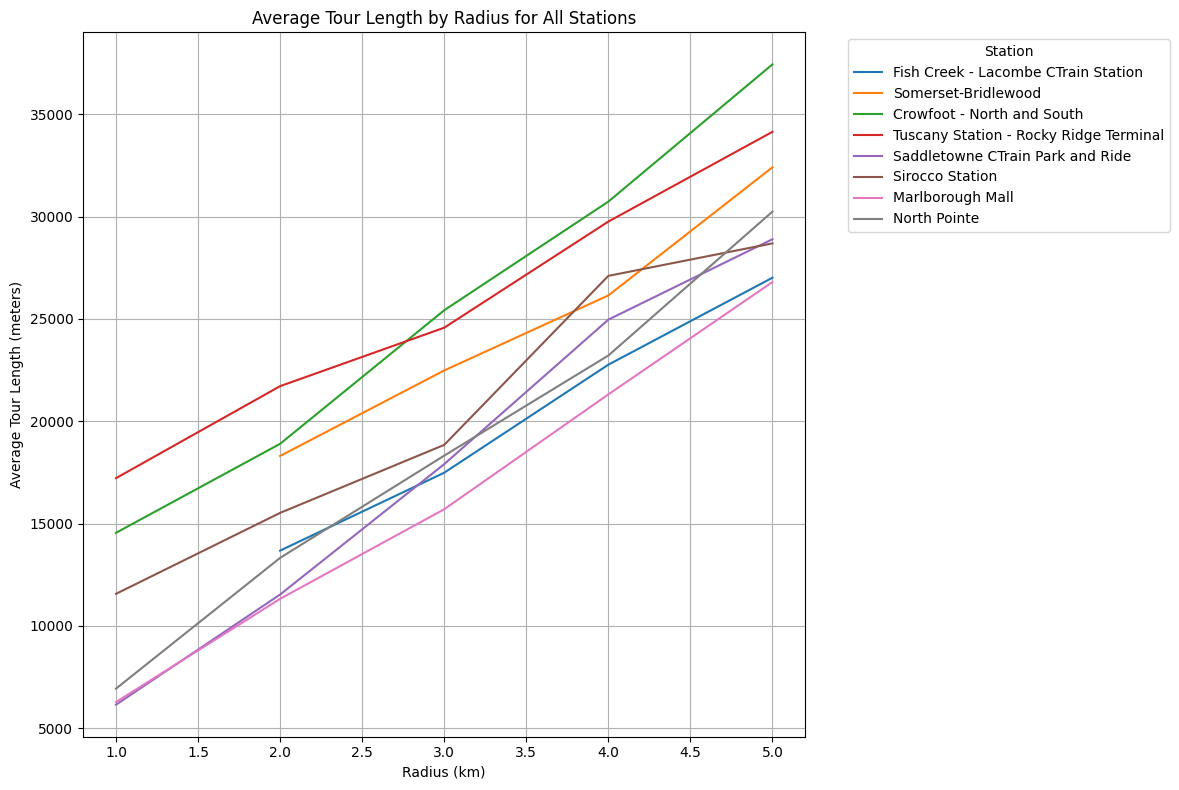

In [5]:
# Group by station and radius, then calculate average tour length
avg_tour_length = df.groupby(['Park_and_Ride_Station', 'Radius'])['Tour_Length'].mean().reset_index()

# Plot for each station
plt.figure(figsize=(12, 8))
for station in stations:
    station_data = avg_tour_length[avg_tour_length['Park_and_Ride_Station'] == station]
    plt.plot(station_data['Radius'], station_data['Tour_Length'], label=station)

plt.title("Average Tour Length by Radius for All Stations")
plt.xlabel("Radius (km)")
plt.ylabel("Average Tour Length (meters)")
plt.legend(title="Station", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

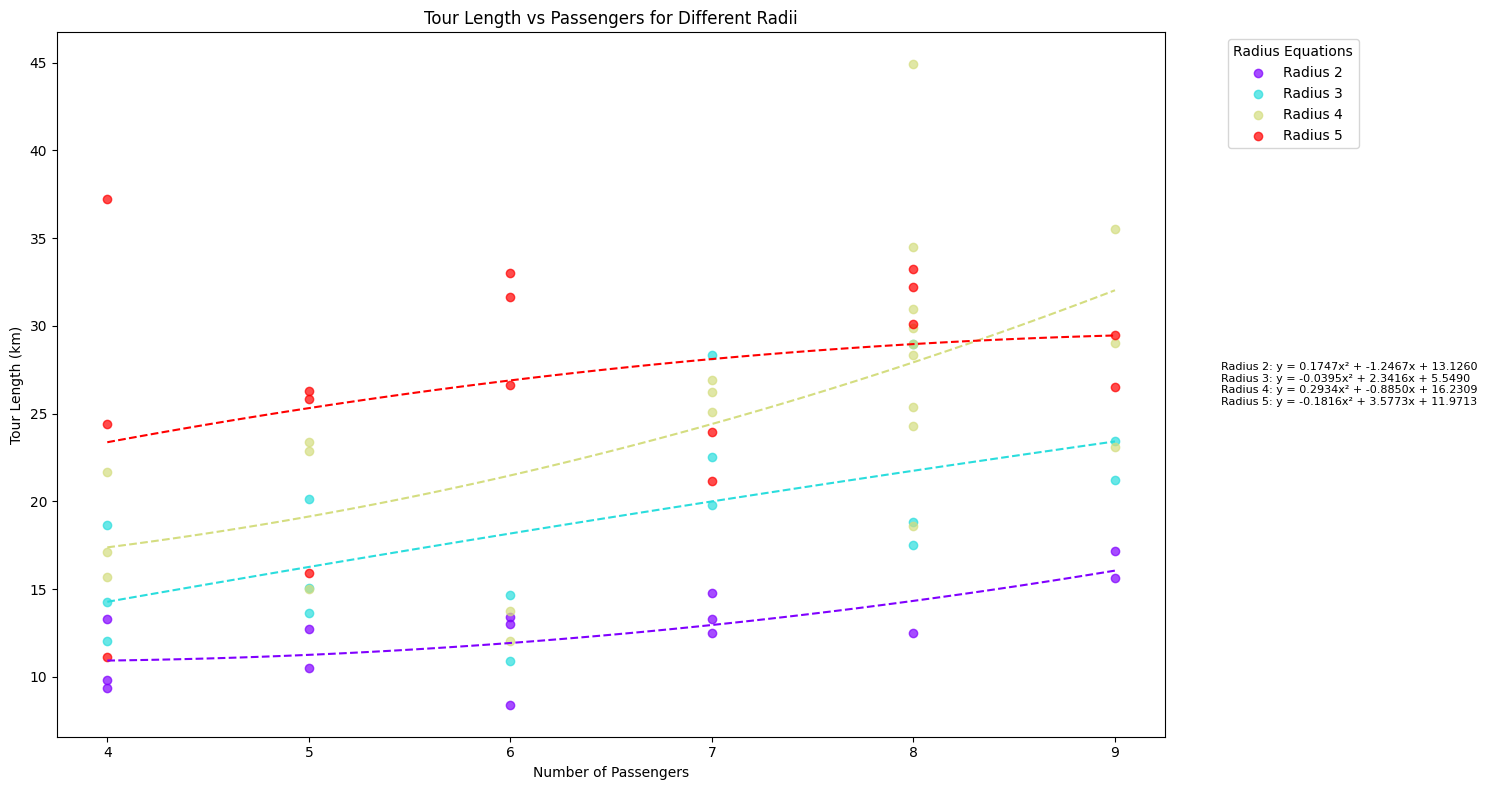

Radius Line Equations:
Radius 2: y = 0.1747x² + -1.2467x + 13.1260
Radius 3: y = -0.0395x² + 2.3416x + 5.5490
Radius 4: y = 0.2934x² + -0.8850x + 16.2309
Radius 5: y = -0.1816x² + 3.5773x + 11.9713


In [ ]:
# Turn this into a classifcation problem instead of regression. Instead of predicting tour length exactly, we can predict the class of tour length
# GOOD FOR PAPER
# plot confusion matrix

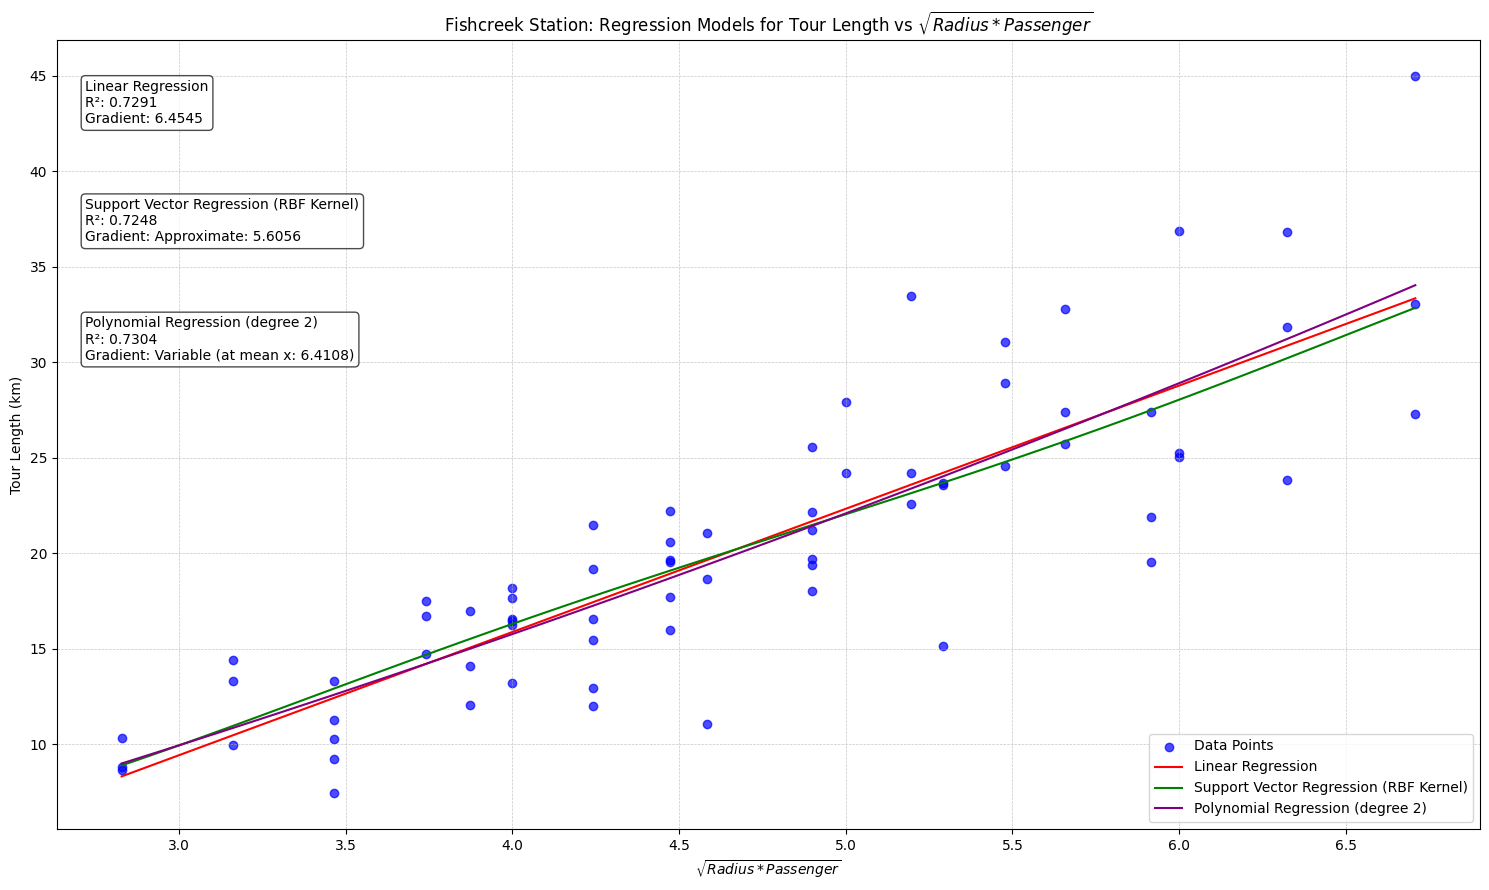


Model Performance and Gradients:
Linear Regression:
R-squared: 0.7291
Gradient: 6.4545
------------------------------
Support Vector Regression (RBF Kernel):
R-squared: 0.7248
Gradient: Approximate: 5.6056
------------------------------
Polynomial Regression (degree 2):
R-squared: 0.7304
Gradient: Variable (at mean x: 6.4108)
------------------------------


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Read the CSV data
df = fishcreek_df

# Clean the data - remove rows with empty Tour_Length
df = df.dropna(subset=['Tour_Length'])

# Convert Tour Length to kilometers
df['Tour_Length_km'] = df['Tour_Length'] / 1000

# Calculate sqrt(Radius * Passengers)
df['Sqrt_Radius_Passengers'] = np.sqrt(df['Radius'] * df['Passengers'])

# Prepare data for regression
X = df['Sqrt_Radius_Passengers'].values.reshape(-1, 1)
y = df['Tour_Length_km'].values

# Function to calculate gradient for different models
def calculate_gradient(model, X, name):
    if name == "Polynomial Regression (degree 2)":
        # For polynomial regression, calculate gradient at mean X
        coeffs = model.named_steps['linearregression'].coef_
        intercept = model.named_steps['linearregression'].intercept_
        x_mean = np.mean(X)
        # Quadratic: a*x^2 + b*x + c
        # Gradient is 2ax + b
        gradient = 2 * coeffs[2] * x_mean + coeffs[1]
        return f"Variable (at mean x: {gradient:.4f})"
    
    elif name == "Support Vector Regression (RBF Kernel)":
        # For SVR, estimate gradient by predicting at points near mean
        x_mean = np.mean(X)
        x_sample = np.array([x_mean - 0.1, x_mean, x_mean + 0.1]).reshape(-1, 1)
        y_sample = model.predict(x_sample)
        # Calculate average gradient
        gradient = np.polyfit(x_sample.flatten(), y_sample, 1)[0]
        return f"Approximate: {gradient:.4f}"
    
    elif name == "Linear Regression":
        # For linear regression, use the coefficient directly
        return f"{model.coef_[0]:.4f}"
    
    return "Not calculable"

# Regression Models
models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression (RBF Kernel)": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    "Polynomial Regression (degree 2)": make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
}

# Plot setup
plt.figure(figsize=(15, 9))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.scatter(df['Sqrt_Radius_Passengers'], df['Tour_Length_km'], alpha=0.7, label='Data Points', color='blue')

# Fit and plot for each model
x_fit = np.linspace(df['Sqrt_Radius_Passengers'].min(), df['Sqrt_Radius_Passengers'].max(), 100).reshape(-1, 1)
colors = ['red', 'green', 'purple']
model_stats = {}

for (name, model), color in zip(models.items(), colors):
    model.fit(X, y)
    y_pred = model.predict(x_fit)
    plt.plot(x_fit, y_pred, label=name, color=color)
    
    # Calculate model statistics
    r_squared = model.score(X, y)
    gradient = calculate_gradient(model, X, name)
    
    model_stats[name] = {
        'R-squared': r_squared,
        'Gradient': gradient
    }

# Annotate statistics on the plot
y_max = df['Tour_Length_km'].max()
for i, (name, stats) in enumerate(model_stats.items()):
    annotation_text = (
        f"{name}\n"
        f"R²: {stats['R-squared']:.4f}\n"
        f"Gradient: {stats['Gradient']}"
    )
    plt.annotate(
        annotation_text, 
        xy=(0.02, 0.95 - i*0.15),  # Vertical spacing
        xycoords='axes fraction',
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
    )

# Annotate the plot
plt.xlabel(r'$\sqrt{Radius * Passenger}$')
plt.ylabel('Tour Length (km)')
plt.title("Fishcreek Station: Regression Models for Tour Length vs $\sqrt{Radius * Passenger}$")
plt.legend()
plt.tight_layout()
plt.show()

# Print additional insights (optional)
print("\nModel Performance and Gradients:")
for name, stats in model_stats.items():
    print(f"{name}:")
    print(f"R-squared: {stats['R-squared']:.4f}")
    print(f"Gradient: {stats['Gradient']}")
    print("-" * 30)

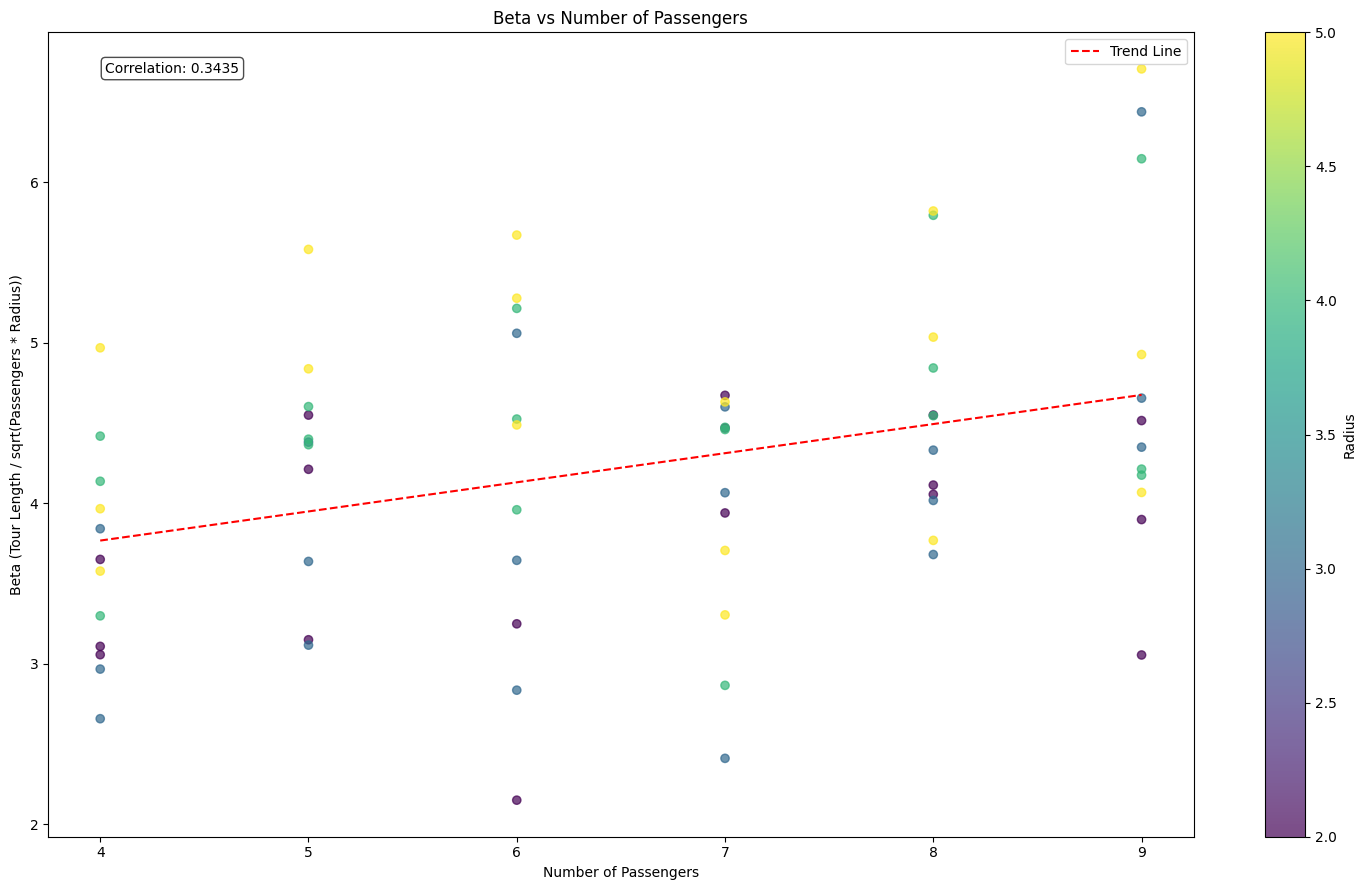


Beta Statistical Summary:
count    70.000000
mean      4.226286
std       0.916187
min       2.149733
25%       3.657519
50%       4.271741
75%       4.624104
max       6.706502
Name: Beta, dtype: float64

Correlation between Passengers and Beta:
0.3435019483187016


c:\Users\bilal\anaconda3\envs\endg511\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\bilal\anaconda3\envs\endg511\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


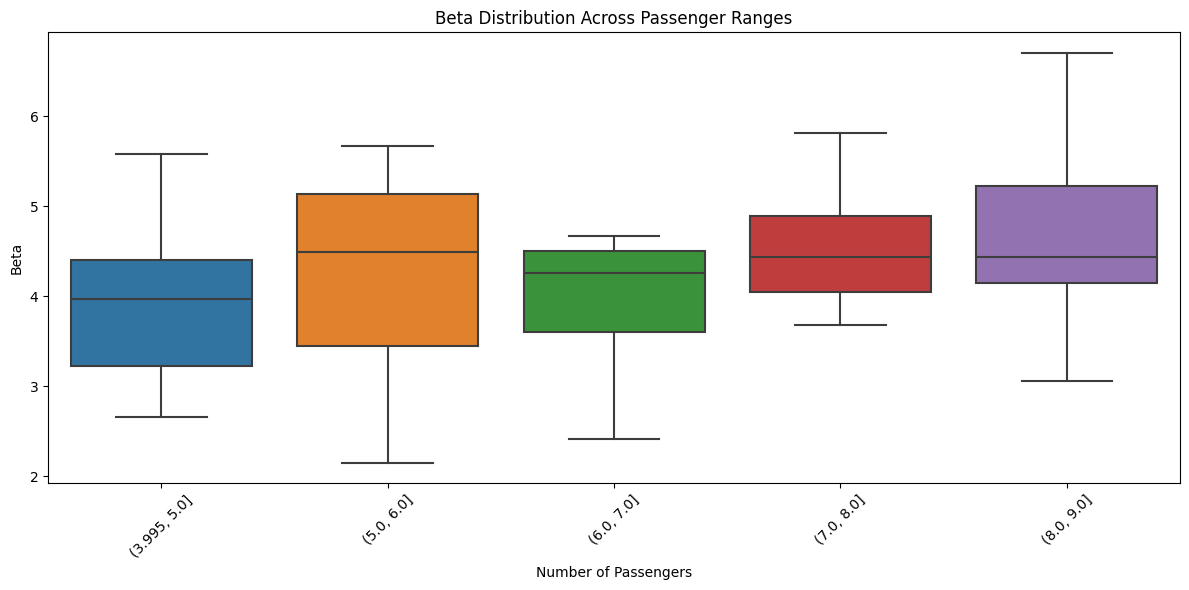

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate Beta
df['Beta'] = (df['Tour_Length']/1000) / np.sqrt(df['Passengers'] * df['Radius'])

# Create the plot
plt.figure(figsize=(15, 9))

# Scatter plot with color gradient based on Radius
scatter = plt.scatter(df['Passengers'], df['Beta'], 
                      c=df['Radius'], 
                      cmap='viridis', 
                      alpha=0.7)

# Add colorbar
plt.colorbar(scatter, label='Radius')

# Add trend line
z = np.polyfit(df['Passengers'], df['Beta'], 1)
p = np.poly1d(z)
plt.plot(df['Passengers'], p(df['Passengers']), "r--", label='Trend Line')

# Labeling
plt.xlabel('Number of Passengers')
plt.ylabel('Beta (Tour Length / sqrt(Passengers * Radius))')
plt.title('Beta vs Number of Passengers')
plt.legend()

# Additional statistical information
correlation = df['Passengers'].corr(df['Beta'])

# Annotate correlation
plt.annotate(f'Correlation: {correlation:.4f}', 
             xy=(0.05, 0.95), 
             xycoords='axes fraction',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

# Print additional statistical insights
print("\nBeta Statistical Summary:")
print(df['Beta'].describe())

print("\nCorrelation between Passengers and Beta:")
print(correlation)

# Box plot to show Beta distribution across different passenger ranges
plt.figure(figsize=(12, 6))
df['Passengers_Bin'] = pd.cut(df['Passengers'], bins=5)
sns.boxplot(x='Passengers_Bin', y='Beta', data=df)
plt.title('Beta Distribution Across Passenger Ranges')
plt.xlabel('Number of Passengers')
plt.ylabel('Beta')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

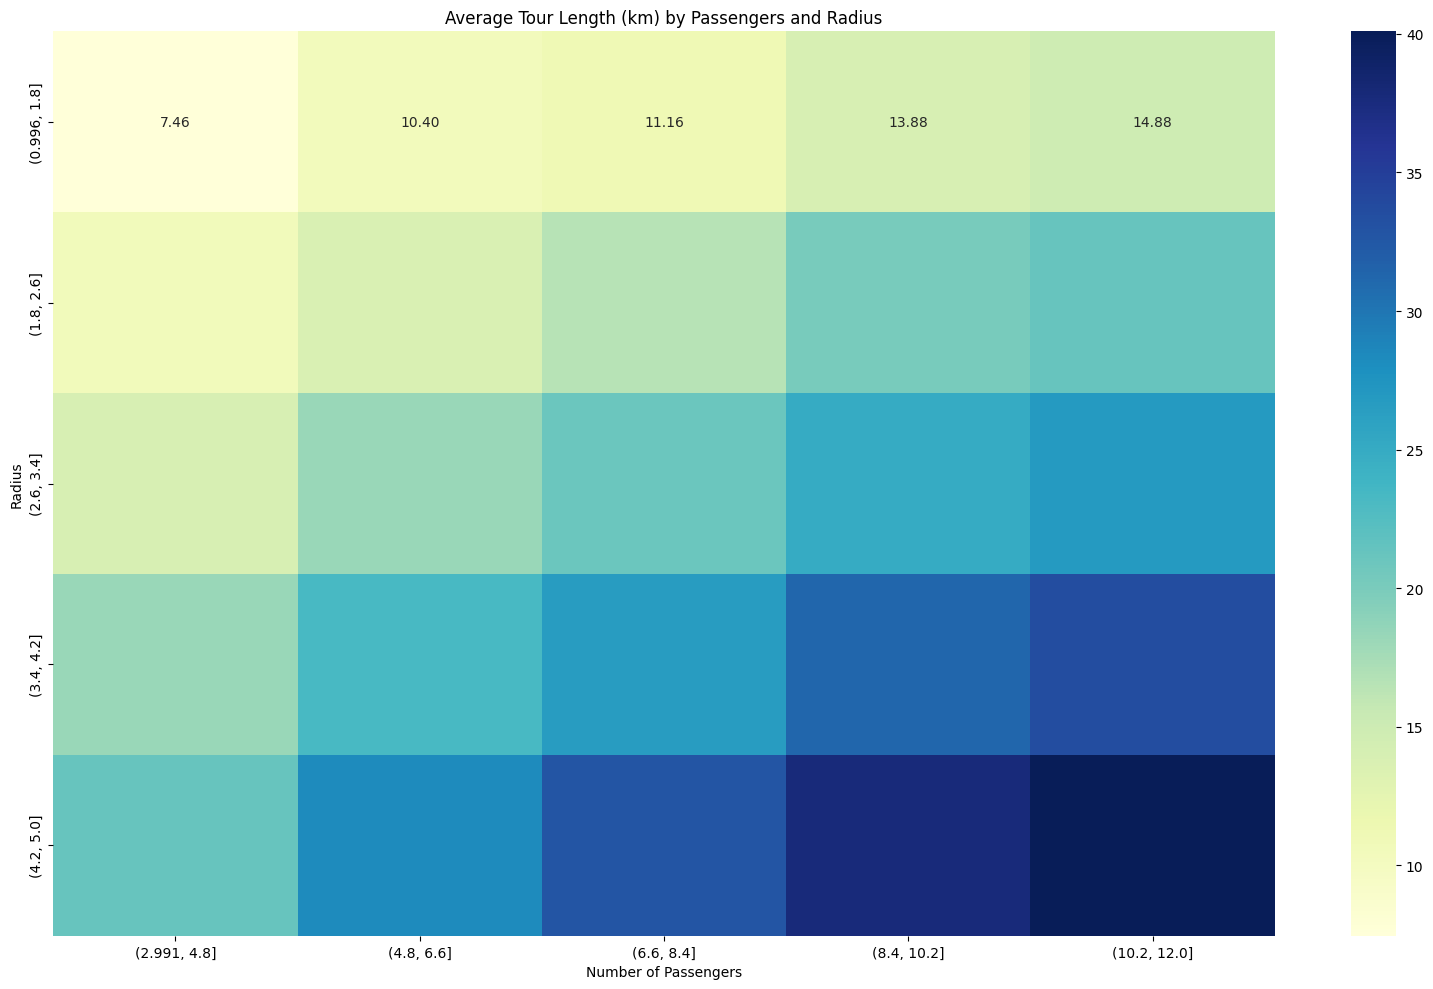


Detailed Tour Length Statistics:
Passengers_Bin  (2.991, 4.8]  (4.8, 6.6]  (6.6, 8.4]  (8.4, 10.2]  \
Radius_Bin                                                          
(0.996, 1.8]        7.455591   10.396361   11.161523    13.879345   
(1.8, 2.6]         10.529300   13.809066   16.520515    20.130576   
(2.6, 3.4]         13.953125   18.202248   21.080011    24.980788   
(3.4, 4.2]         18.251120   23.330563   26.706731    31.290621   
(4.2, 5.0]         21.329301   28.295670   32.814863    37.712834   

Passengers_Bin  (10.2, 12.0]  
Radius_Bin                    
(0.996, 1.8]       14.875415  
(1.8, 2.6]         21.257156  
(2.6, 3.4]         26.914897  
(3.4, 4.2]         33.578440  
(4.2, 5.0]         40.093424  

Distribution of Tours in Each Bin:
Passengers_Bin  (2.991, 4.8]  (4.8, 6.6]  (6.6, 8.4]  (8.4, 10.2]  \
Radius_Bin                                                          
(0.996, 1.8]              32          30          31           29   
(1.8, 2.6]            

C:\Users\bilal\AppData\Local\Temp\ipykernel_40360\2489542158.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distribution = df.groupby(['Radius_Bin', 'Passengers_Bin']).size().unstack()


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert Tour Length to kilometers
df['Tour_Length_km'] = df['Tour_Length'] / 1000

# Create bins for passengers and radius
df['Passengers_Bin'] = pd.cut(df['Passengers'], bins=5)
df['Radius_Bin'] = pd.cut(df['Radius'], bins=5)

# Create pivot table to show average tour length
pivot_table = df.pivot_table(
    values='Tour_Length_km', 
    index='Radius_Bin', 
    columns='Passengers_Bin', 
    aggfunc='mean'
)

# Visualization
plt.figure(figsize=(16, 10))

# Heatmap of average tour length
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Average Tour Length (km) by Passengers and Radius')
plt.xlabel('Number of Passengers')
plt.ylabel('Radius')

plt.tight_layout()
plt.show()

# Additional detailed view
print("\nDetailed Tour Length Statistics:")
print(pivot_table)

# Count distribution
print("\nDistribution of Tours in Each Bin:")
distribution = df.groupby(['Radius_Bin', 'Passengers_Bin']).size().unstack()
print(distribution)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best R-squared Score: 0.5272229037811165


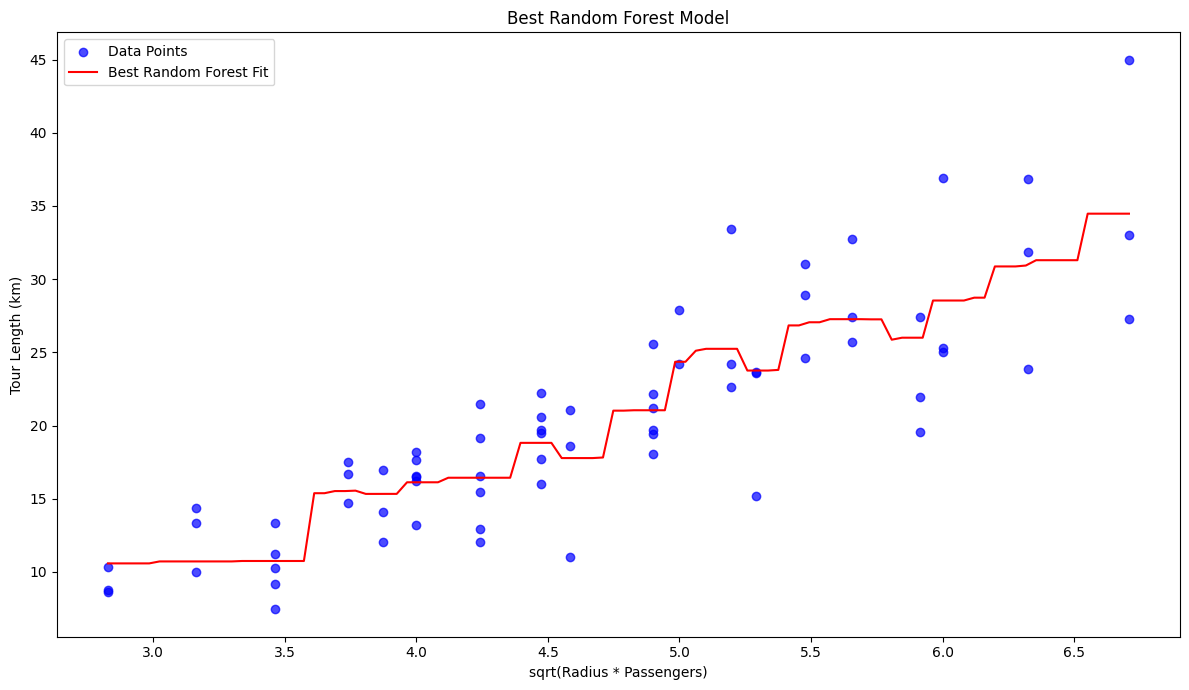

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    # 'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Perform Grid Search with 5-fold CV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2', verbose=2)
grid_search.fit(X, y)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best R-squared Score:", grid_search.best_score_)

# Use the best estimator to predict
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(x_fit)

# Plot the results
plt.figure(figsize=(12, 7))
plt.scatter(df['Sqrt_Radius_Passengers'], df['Tour_Length_km'], alpha=0.7, label='Data Points', color='blue')
plt.plot(x_fit, y_pred, label='Best Random Forest Fit', color='red')
plt.xlabel('sqrt(Radius * Passengers)')
plt.ylabel('Tour Length (km)')
plt.title('Best Random Forest Model')
plt.legend()
plt.tight_layout()
plt.show()


### Somerset Station

In [15]:
print(somerset_df)

    Park_and_Ride_Station  Passengers  Radius  Tour_Length
72    Somerset-Bridlewood           4       2    12832.744
73    Somerset-Bridlewood           4       2    11263.880
74    Somerset-Bridlewood           4       2     8880.649
75    Somerset-Bridlewood           4       3    16828.934
76    Somerset-Bridlewood           4       3     8489.132
..                    ...         ...     ...          ...
171   Somerset-Bridlewood          12       3    22312.775
172   Somerset-Bridlewood          12       3    29622.992
173   Somerset-Bridlewood          12       3    24996.427
174   Somerset-Bridlewood          12       4    41173.114
175   Somerset-Bridlewood          12       4    35679.927

[96 rows x 4 columns]


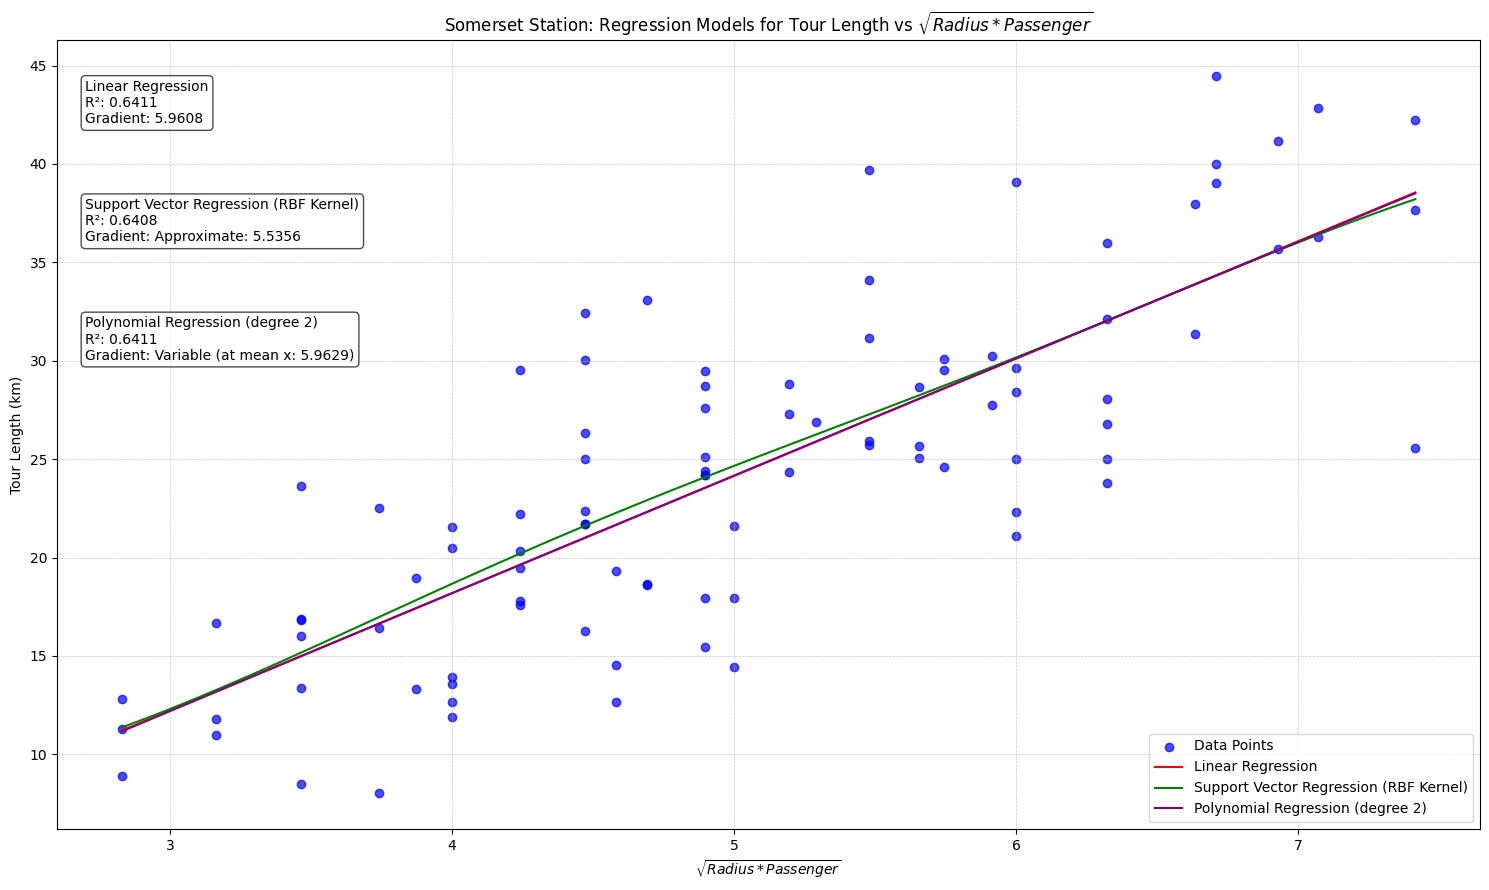


Model Performance and Gradients:
Linear Regression:
R-squared: 0.6411
Gradient: 5.9608
------------------------------
Support Vector Regression (RBF Kernel):
R-squared: 0.6408
Gradient: Approximate: 5.5356
------------------------------
Polynomial Regression (degree 2):
R-squared: 0.6411
Gradient: Variable (at mean x: 5.9629)
------------------------------


In [12]:
df = somerset_df

# Clean the data - remove rows with empty Tour_Length
df = df.dropna(subset=['Tour_Length'])

# Convert Tour Length to kilometers
df['Tour_Length_km'] = df['Tour_Length'] / 1000

# Calculate sqrt(Radius * Passengers)
df['Sqrt_Radius_Passengers'] = np.sqrt(df['Radius'] * df['Passengers'])

# Prepare data for regression
X = df['Sqrt_Radius_Passengers'].values.reshape(-1, 1)
y = df['Tour_Length_km'].values

# Function to calculate gradient for different models
def calculate_gradient(model, X, name):
    if name == "Polynomial Regression (degree 2)":
        # For polynomial regression, calculate gradient at mean X
        coeffs = model.named_steps['linearregression'].coef_
        intercept = model.named_steps['linearregression'].intercept_
        x_mean = np.mean(X)
        # Quadratic: a*x^2 + b*x + c
        # Gradient is 2ax + b
        gradient = 2 * coeffs[2] * x_mean + coeffs[1]
        return f"Variable (at mean x: {gradient:.4f})"
    
    elif name == "Support Vector Regression (RBF Kernel)":
        # For SVR, estimate gradient by predicting at points near mean
        x_mean = np.mean(X)
        x_sample = np.array([x_mean - 0.1, x_mean, x_mean + 0.1]).reshape(-1, 1)
        y_sample = model.predict(x_sample)
        # Calculate average gradient
        gradient = np.polyfit(x_sample.flatten(), y_sample, 1)[0]
        return f"Approximate: {gradient:.4f}"
    
    elif name == "Linear Regression":
        # For linear regression, use the coefficient directly
        return f"{model.coef_[0]:.4f}"
    
    return "Not calculable"

# Regression Models
models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression (RBF Kernel)": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    "Polynomial Regression (degree 2)": make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
}

# Plot setup
plt.figure(figsize=(15, 9))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.scatter(df['Sqrt_Radius_Passengers'], df['Tour_Length_km'], alpha=0.7, label='Data Points', color='blue')

# Fit and plot for each model
x_fit = np.linspace(df['Sqrt_Radius_Passengers'].min(), df['Sqrt_Radius_Passengers'].max(), 100).reshape(-1, 1)
colors = ['red', 'green', 'purple']
model_stats = {}

for (name, model), color in zip(models.items(), colors):
    model.fit(X, y)
    y_pred = model.predict(x_fit)
    plt.plot(x_fit, y_pred, label=name, color=color)
    
    # Calculate model statistics
    r_squared = model.score(X, y)
    gradient = calculate_gradient(model, X, name)
    
    model_stats[name] = {
        'R-squared': r_squared,
        'Gradient': gradient
    }

# Annotate statistics on the plot
y_max = df['Tour_Length_km'].max()
for i, (name, stats) in enumerate(model_stats.items()):
    annotation_text = (
        f"{name}\n"
        f"R²: {stats['R-squared']:.4f}\n"
        f"Gradient: {stats['Gradient']}"
    )
    plt.annotate(
        annotation_text, 
        xy=(0.02, 0.95 - i*0.15),  # Vertical spacing
        xycoords='axes fraction',
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
    )

# Annotate the plot
plt.xlabel(r'$\sqrt{Radius * Passenger}$')
plt.ylabel('Tour Length (km)')
plt.title("Somerset Station: Regression Models for Tour Length vs $\sqrt{Radius * Passenger}$")
plt.legend()
plt.tight_layout()
plt.show()

# Print additional insights (optional)
print("\nModel Performance and Gradients:")
for name, stats in model_stats.items():
    print(f"{name}:")
    print(f"R-squared: {stats['R-squared']:.4f}")
    print(f"Gradient: {stats['Gradient']}")
    print("-" * 30)

### Crowfoot Station

In [13]:
df = crowfoot_df
print(df)

          Park_and_Ride_Station  Passengers  Radius  Tour_Length
176  Crowfoot - North and South           3       1    10126.275
177  Crowfoot - North and South           3       1     9034.813
178  Crowfoot - North and South           3       1    12168.393
179  Crowfoot - North and South           3       2    13970.190
180  Crowfoot - North and South           3       2    15684.979
..                          ...         ...     ...          ...
306  Crowfoot - North and South          11       4    36271.581
307  Crowfoot - North and South          11       4    38123.788
308  Crowfoot - North and South          11       5    44811.759
309  Crowfoot - North and South          11       5    48506.158
310  Crowfoot - North and South          11       5    55521.399

[130 rows x 4 columns]


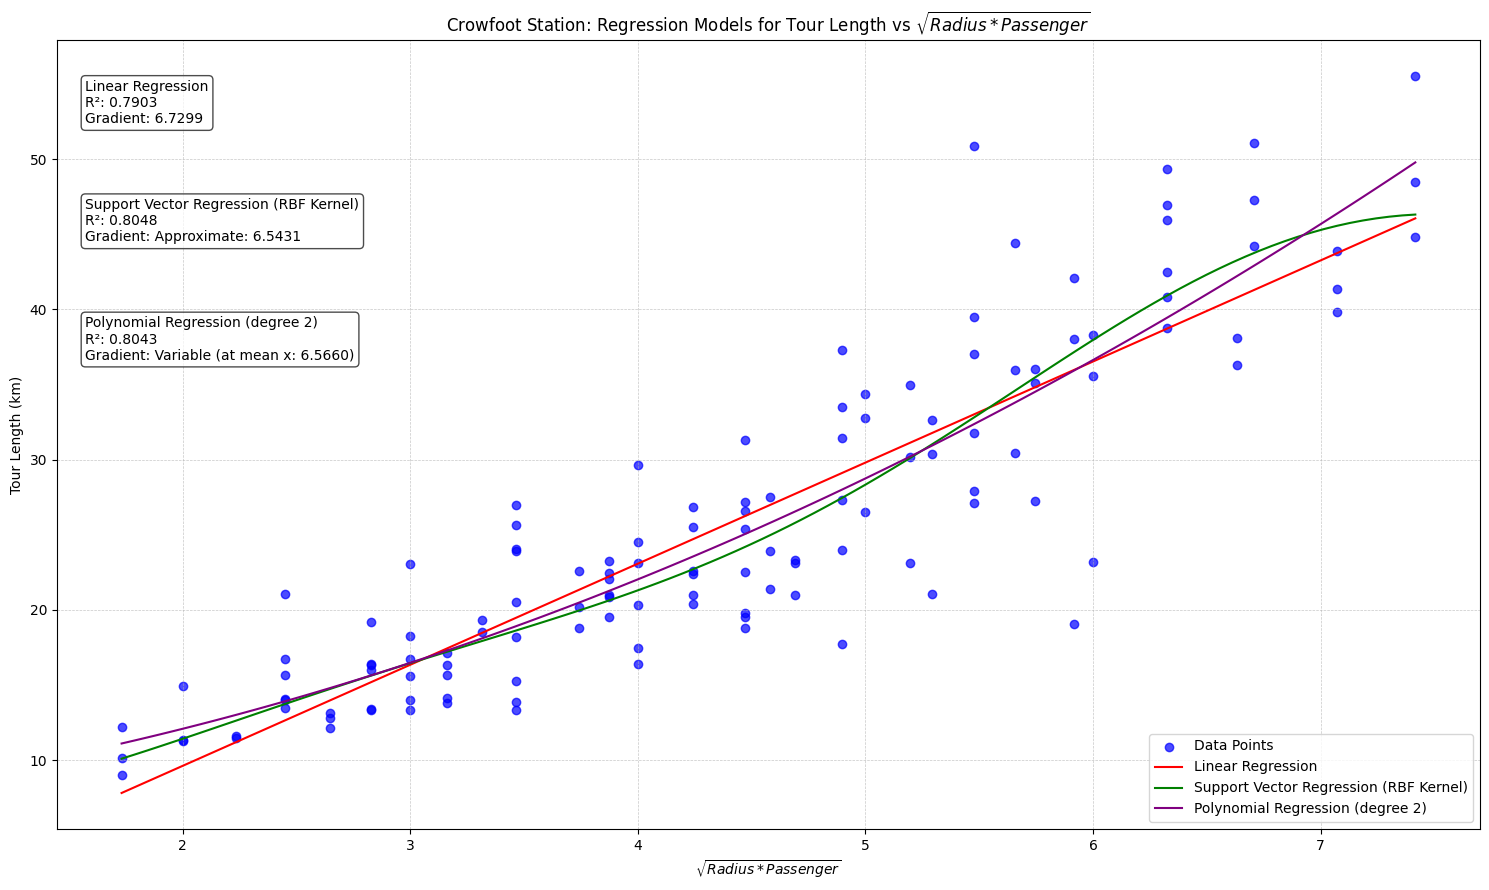


Model Performance and Gradients:
Linear Regression:
R-squared: 0.7903
Gradient: 6.7299
------------------------------
Support Vector Regression (RBF Kernel):
R-squared: 0.8048
Gradient: Approximate: 6.5431
------------------------------
Polynomial Regression (degree 2):
R-squared: 0.8043
Gradient: Variable (at mean x: 6.5660)
------------------------------


In [14]:
# Clean the data - remove rows with empty Tour_Length
df = df.dropna(subset=['Tour_Length'])

# Convert Tour Length to kilometers
df['Tour_Length_km'] = df['Tour_Length'] / 1000

# Calculate sqrt(Radius * Passengers)
df['Sqrt_Radius_Passengers'] = np.sqrt(df['Radius'] * df['Passengers'])

# Prepare data for regression
X = df['Sqrt_Radius_Passengers'].values.reshape(-1, 1)
y = df['Tour_Length_km'].values

# Function to calculate gradient for different models
def calculate_gradient(model, X, name):
    if name == "Polynomial Regression (degree 2)":
        # For polynomial regression, calculate gradient at mean X
        coeffs = model.named_steps['linearregression'].coef_
        intercept = model.named_steps['linearregression'].intercept_
        x_mean = np.mean(X)
        # Quadratic: a*x^2 + b*x + c
        # Gradient is 2ax + b
        gradient = 2 * coeffs[2] * x_mean + coeffs[1]
        return f"Variable (at mean x: {gradient:.4f})"
    
    elif name == "Support Vector Regression (RBF Kernel)":
        # For SVR, estimate gradient by predicting at points near mean
        x_mean = np.mean(X)
        x_sample = np.array([x_mean - 0.1, x_mean, x_mean + 0.1]).reshape(-1, 1)
        y_sample = model.predict(x_sample)
        # Calculate average gradient
        gradient = np.polyfit(x_sample.flatten(), y_sample, 1)[0]
        return f"Approximate: {gradient:.4f}"
    
    elif name == "Linear Regression":
        # For linear regression, use the coefficient directly
        return f"{model.coef_[0]:.4f}"
    
    return "Not calculable"

# Regression Models
models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression (RBF Kernel)": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    "Polynomial Regression (degree 2)": make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
}

# Plot setup
plt.figure(figsize=(15, 9))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.scatter(df['Sqrt_Radius_Passengers'], df['Tour_Length_km'], alpha=0.7, label='Data Points', color='blue')

# Fit and plot for each model
x_fit = np.linspace(df['Sqrt_Radius_Passengers'].min(), df['Sqrt_Radius_Passengers'].max(), 100).reshape(-1, 1)
colors = ['red', 'green', 'purple']
model_stats = {}

for (name, model), color in zip(models.items(), colors):
    model.fit(X, y)
    y_pred = model.predict(x_fit)
    plt.plot(x_fit, y_pred, label=name, color=color)
    
    # Calculate model statistics
    r_squared = model.score(X, y)
    gradient = calculate_gradient(model, X, name)
    
    model_stats[name] = {
        'R-squared': r_squared,
        'Gradient': gradient
    }

# Annotate statistics on the plot
y_max = df['Tour_Length_km'].max()
for i, (name, stats) in enumerate(model_stats.items()):
    annotation_text = (
        f"{name}\n"
        f"R²: {stats['R-squared']:.4f}\n"
        f"Gradient: {stats['Gradient']}"
    )
    plt.annotate(
        annotation_text, 
        xy=(0.02, 0.95 - i*0.15),  # Vertical spacing
        xycoords='axes fraction',
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
    )

# Annotate the plot
plt.xlabel(r'$\sqrt{Radius * Passenger}$')
plt.ylabel('Tour Length (km)')
plt.title("Crowfoot Station: Regression Models for Tour Length vs $\sqrt{Radius * Passenger}$")
plt.legend()
plt.tight_layout()
plt.show()

# Print additional insights (optional)
print("\nModel Performance and Gradients:")
for name, stats in model_stats.items():
    print(f"{name}:")
    print(f"R-squared: {stats['R-squared']:.4f}")
    print(f"Gradient: {stats['Gradient']}")
    print("-" * 30)

### Tuscany Station

In [15]:
df = tuscany_df
print(df)

                      Park_and_Ride_Station  Passengers  Radius  Tour_Length
311  Tuscany Station - Rocky Ridge Terminal           3       1     4440.340
312  Tuscany Station - Rocky Ridge Terminal           3       1    12677.065
313  Tuscany Station - Rocky Ridge Terminal           3       1    12177.632
314  Tuscany Station - Rocky Ridge Terminal           3       2    12982.141
315  Tuscany Station - Rocky Ridge Terminal           3       2     5685.396
..                                      ...         ...     ...          ...
441  Tuscany Station - Rocky Ridge Terminal          11       4    36878.641
442  Tuscany Station - Rocky Ridge Terminal          11       4    38977.023
443  Tuscany Station - Rocky Ridge Terminal          11       5    38146.152
444  Tuscany Station - Rocky Ridge Terminal          11       5    42879.878
445  Tuscany Station - Rocky Ridge Terminal          11       5    38477.713

[135 rows x 4 columns]


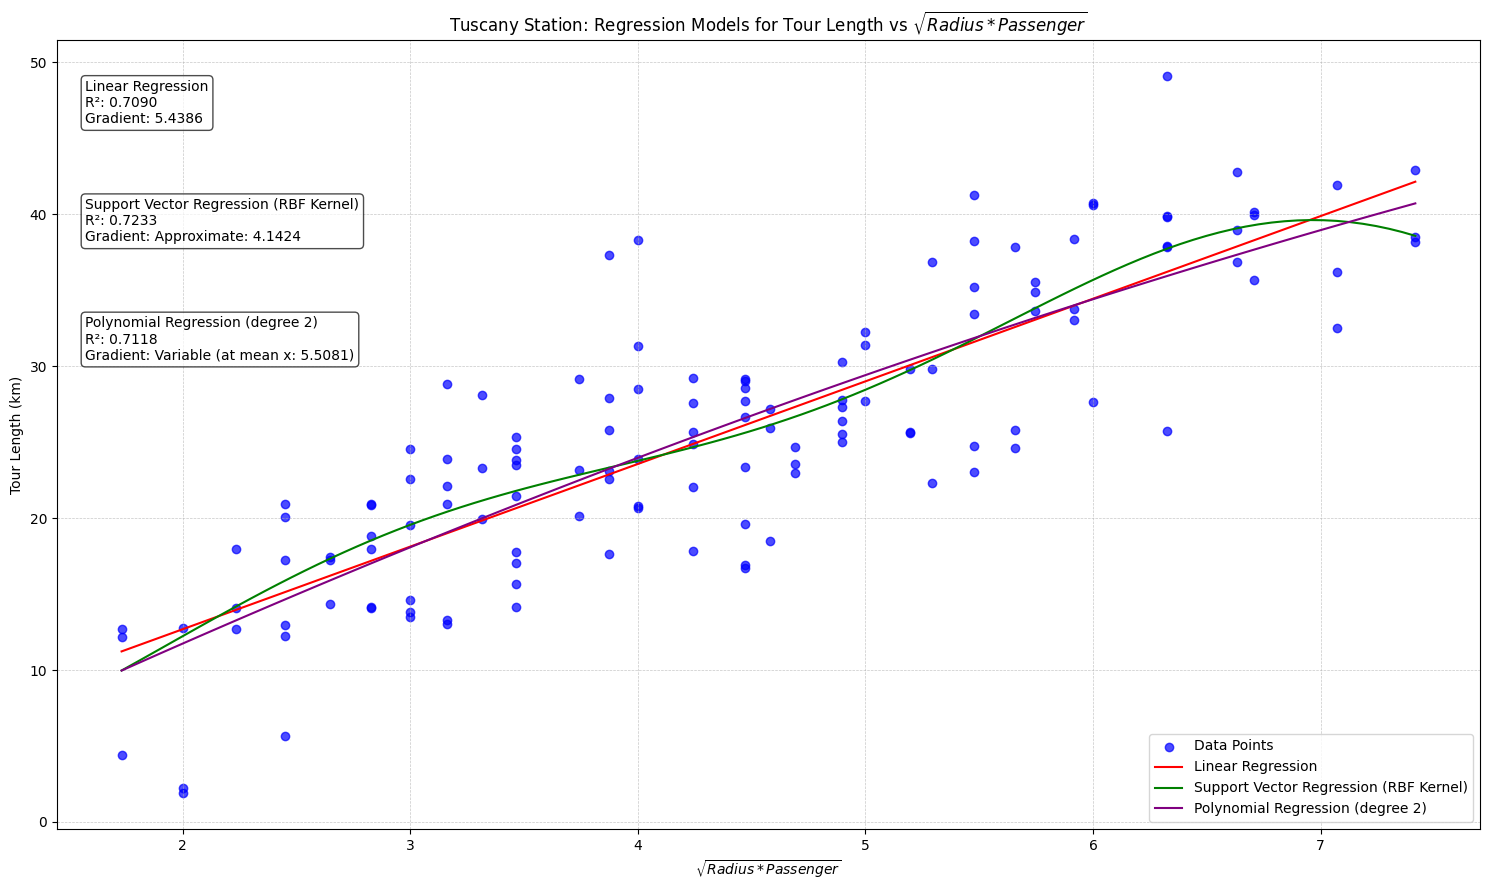


Model Performance and Gradients:
Linear Regression:
R-squared: 0.7090
Gradient: 5.4386
------------------------------
Support Vector Regression (RBF Kernel):
R-squared: 0.7233
Gradient: Approximate: 4.1424
------------------------------
Polynomial Regression (degree 2):
R-squared: 0.7118
Gradient: Variable (at mean x: 5.5081)
------------------------------


In [16]:
# Clean the data - remove rows with empty Tour_Length
df = df.dropna(subset=['Tour_Length'])

# Convert Tour Length to kilometers
df['Tour_Length_km'] = df['Tour_Length'] / 1000

# Calculate sqrt(Radius * Passengers)
df['Sqrt_Radius_Passengers'] = np.sqrt(df['Radius'] * df['Passengers'])

# Prepare data for regression
X = df['Sqrt_Radius_Passengers'].values.reshape(-1, 1)
y = df['Tour_Length_km'].values

# Function to calculate gradient for different models
def calculate_gradient(model, X, name):
    if name == "Polynomial Regression (degree 2)":
        # For polynomial regression, calculate gradient at mean X
        coeffs = model.named_steps['linearregression'].coef_
        intercept = model.named_steps['linearregression'].intercept_
        x_mean = np.mean(X)
        # Quadratic: a*x^2 + b*x + c
        # Gradient is 2ax + b
        gradient = 2 * coeffs[2] * x_mean + coeffs[1]
        return f"Variable (at mean x: {gradient:.4f})"
    
    elif name == "Support Vector Regression (RBF Kernel)":
        # For SVR, estimate gradient by predicting at points near mean
        x_mean = np.mean(X)
        x_sample = np.array([x_mean - 0.1, x_mean, x_mean + 0.1]).reshape(-1, 1)
        y_sample = model.predict(x_sample)
        # Calculate average gradient
        gradient = np.polyfit(x_sample.flatten(), y_sample, 1)[0]
        return f"Approximate: {gradient:.4f}"
    
    elif name == "Linear Regression":
        # For linear regression, use the coefficient directly
        return f"{model.coef_[0]:.4f}"
    
    return "Not calculable"

# Regression Models
models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression (RBF Kernel)": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    "Polynomial Regression (degree 2)": make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
}

# Plot setup
plt.figure(figsize=(15, 9))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.scatter(df['Sqrt_Radius_Passengers'], df['Tour_Length_km'], alpha=0.7, label='Data Points', color='blue')

# Fit and plot for each model
x_fit = np.linspace(df['Sqrt_Radius_Passengers'].min(), df['Sqrt_Radius_Passengers'].max(), 100).reshape(-1, 1)
colors = ['red', 'green', 'purple']
model_stats = {}

for (name, model), color in zip(models.items(), colors):
    model.fit(X, y)
    y_pred = model.predict(x_fit)
    plt.plot(x_fit, y_pred, label=name, color=color)
    
    # Calculate model statistics
    r_squared = model.score(X, y)
    gradient = calculate_gradient(model, X, name)
    
    model_stats[name] = {
        'R-squared': r_squared,
        'Gradient': gradient
    }

# Annotate statistics on the plot
y_max = df['Tour_Length_km'].max()
for i, (name, stats) in enumerate(model_stats.items()):
    annotation_text = (
        f"{name}\n"
        f"R²: {stats['R-squared']:.4f}\n"
        f"Gradient: {stats['Gradient']}"
    )
    plt.annotate(
        annotation_text, 
        xy=(0.02, 0.95 - i*0.15),  # Vertical spacing
        xycoords='axes fraction',
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
    )

# Annotate the plot
plt.xlabel(r'$\sqrt{Radius * Passenger}$')
plt.ylabel('Tour Length (km)')
plt.title("Tuscany Station: Regression Models for Tour Length vs $\sqrt{Radius * Passenger}$")
plt.legend()
plt.tight_layout()
plt.show()

# Print additional insights (optional)
print("\nModel Performance and Gradients:")
for name, stats in model_stats.items():
    print(f"{name}:")
    print(f"R-squared: {stats['R-squared']:.4f}")
    print(f"Gradient: {stats['Gradient']}")
    print("-" * 30)

### Saddletown Station

In [17]:
df = saddletown_df
print(df)

                Park_and_Ride_Station  Passengers  Radius  Tour_Length
446  Saddletowne CTrain Park and Ride           3       1     4422.479
447  Saddletowne CTrain Park and Ride           3       1     4903.174
448  Saddletowne CTrain Park and Ride           3       1     3558.389
449  Saddletowne CTrain Park and Ride           3       2     7585.006
450  Saddletowne CTrain Park and Ride           3       2     8606.889
..                                ...         ...     ...          ...
575  Saddletowne CTrain Park and Ride          11       4    29305.701
576  Saddletowne CTrain Park and Ride          11       4    31792.997
577  Saddletowne CTrain Park and Ride          11       4    24405.172
578  Saddletowne CTrain Park and Ride          11       5    41273.582
579  Saddletowne CTrain Park and Ride          11       5    38073.138

[121 rows x 4 columns]


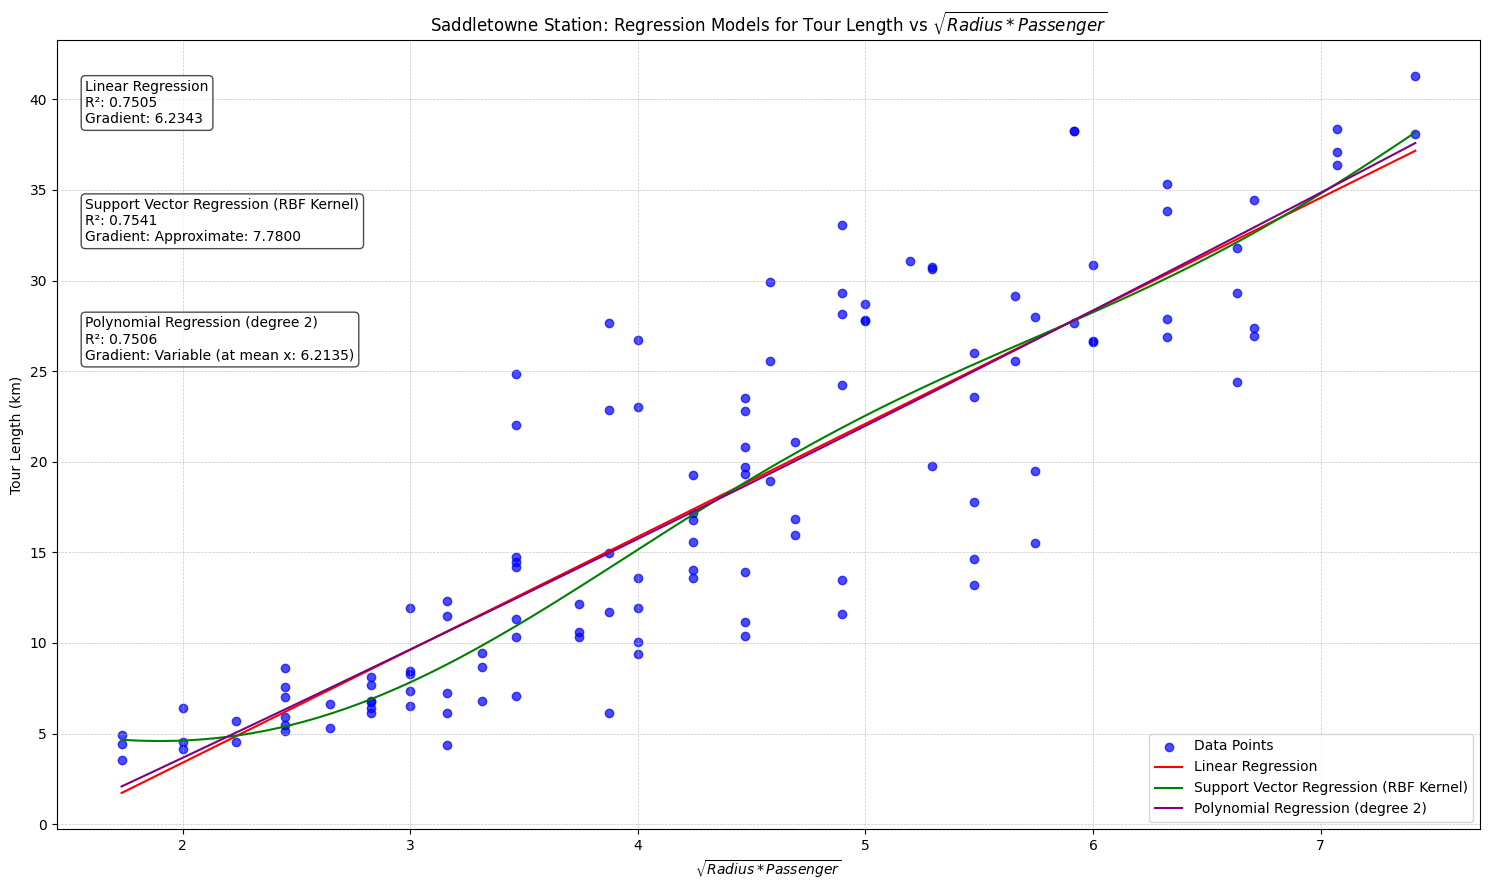


Model Performance and Gradients:
Linear Regression:
R-squared: 0.7505
Gradient: 6.2343
------------------------------
Support Vector Regression (RBF Kernel):
R-squared: 0.7541
Gradient: Approximate: 7.7800
------------------------------
Polynomial Regression (degree 2):
R-squared: 0.7506
Gradient: Variable (at mean x: 6.2135)
------------------------------


In [18]:
# Clean the data - remove rows with empty Tour_Length
df = df.dropna(subset=['Tour_Length'])

# Convert Tour Length to kilometers
df['Tour_Length_km'] = df['Tour_Length'] / 1000

# Calculate sqrt(Radius * Passengers)
df['Sqrt_Radius_Passengers'] = np.sqrt(df['Radius'] * df['Passengers'])

# Prepare data for regression
X = df['Sqrt_Radius_Passengers'].values.reshape(-1, 1)
y = df['Tour_Length_km'].values

# Function to calculate gradient for different models
def calculate_gradient(model, X, name):
    if name == "Polynomial Regression (degree 2)":
        # For polynomial regression, calculate gradient at mean X
        coeffs = model.named_steps['linearregression'].coef_
        intercept = model.named_steps['linearregression'].intercept_
        x_mean = np.mean(X)
        # Quadratic: a*x^2 + b*x + c
        # Gradient is 2ax + b
        gradient = 2 * coeffs[2] * x_mean + coeffs[1]
        return f"Variable (at mean x: {gradient:.4f})"
    
    elif name == "Support Vector Regression (RBF Kernel)":
        # For SVR, estimate gradient by predicting at points near mean
        x_mean = np.mean(X)
        x_sample = np.array([x_mean - 0.1, x_mean, x_mean + 0.1]).reshape(-1, 1)
        y_sample = model.predict(x_sample)
        # Calculate average gradient
        gradient = np.polyfit(x_sample.flatten(), y_sample, 1)[0]
        return f"Approximate: {gradient:.4f}"
    
    elif name == "Linear Regression":
        # For linear regression, use the coefficient directly
        return f"{model.coef_[0]:.4f}"
    
    return "Not calculable"

# Regression Models
models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression (RBF Kernel)": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    "Polynomial Regression (degree 2)": make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
}

# Plot setup
plt.figure(figsize=(15, 9))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.scatter(df['Sqrt_Radius_Passengers'], df['Tour_Length_km'], alpha=0.7, label='Data Points', color='blue')

# Fit and plot for each model
x_fit = np.linspace(df['Sqrt_Radius_Passengers'].min(), df['Sqrt_Radius_Passengers'].max(), 100).reshape(-1, 1)
colors = ['red', 'green', 'purple']
model_stats = {}

for (name, model), color in zip(models.items(), colors):
    model.fit(X, y)
    y_pred = model.predict(x_fit)
    plt.plot(x_fit, y_pred, label=name, color=color)
    
    # Calculate model statistics
    r_squared = model.score(X, y)
    gradient = calculate_gradient(model, X, name)
    
    model_stats[name] = {
        'R-squared': r_squared,
        'Gradient': gradient
    }

# Annotate statistics on the plot
y_max = df['Tour_Length_km'].max()
for i, (name, stats) in enumerate(model_stats.items()):
    annotation_text = (
        f"{name}\n"
        f"R²: {stats['R-squared']:.4f}\n"
        f"Gradient: {stats['Gradient']}"
    )
    plt.annotate(
        annotation_text, 
        xy=(0.02, 0.95 - i*0.15),  # Vertical spacing
        xycoords='axes fraction',
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
    )

# Annotate the plot
plt.xlabel(r'$\sqrt{Radius * Passenger}$')
plt.ylabel('Tour Length (km)')
plt.title("Saddletowne Station: Regression Models for Tour Length vs $\sqrt{Radius * Passenger}$")
plt.legend()
plt.tight_layout()
plt.show()

# Print additional insights (optional)
print("\nModel Performance and Gradients:")
for name, stats in model_stats.items():
    print(f"{name}:")
    print(f"R-squared: {stats['R-squared']:.4f}")
    print(f"Gradient: {stats['Gradient']}")
    print("-" * 30)

### Sirocco Station

In [19]:
df = sirocco_df
print(df)

    Park_and_Ride_Station  Passengers  Radius  Tour_Length
581       Sirocco Station           3       1     3856.224
582       Sirocco Station           3       1    13441.279
583       Sirocco Station           3       1    10982.027
584       Sirocco Station           3       2     6701.468
585       Sirocco Station           3       2     6788.049
..                    ...         ...     ...          ...
710       Sirocco Station          11       4    41078.605
711       Sirocco Station          11       4    38549.036
712       Sirocco Station          11       4    38298.082
713       Sirocco Station          11       5    39125.146
715       Sirocco Station          11       5    31353.765

[130 rows x 4 columns]


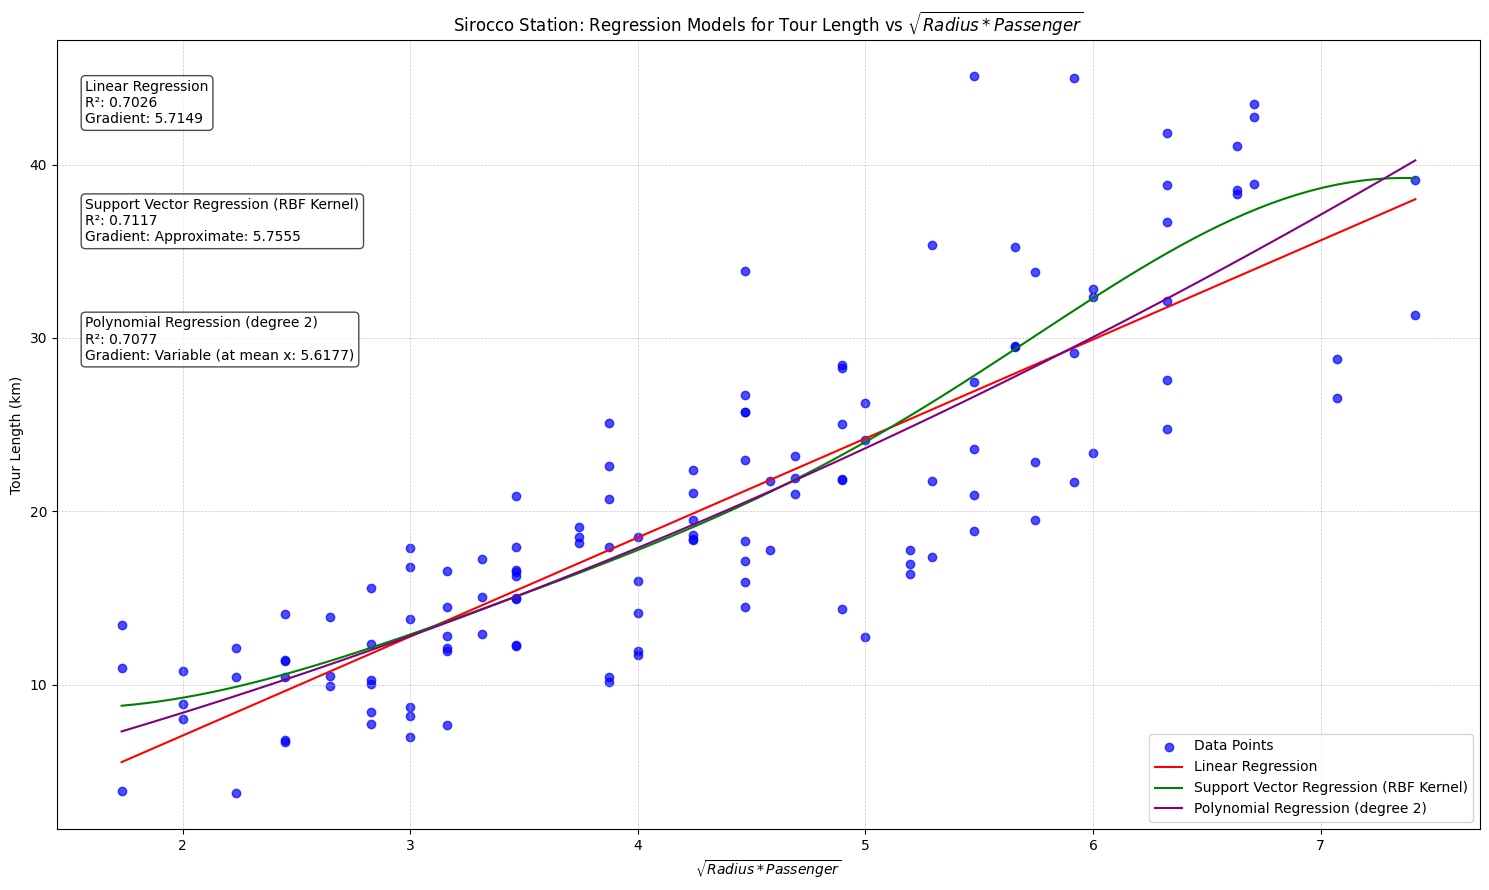


Model Performance and Gradients:
Linear Regression:
R-squared: 0.7026
Gradient: 5.7149
------------------------------
Support Vector Regression (RBF Kernel):
R-squared: 0.7117
Gradient: Approximate: 5.7555
------------------------------
Polynomial Regression (degree 2):
R-squared: 0.7077
Gradient: Variable (at mean x: 5.6177)
------------------------------


In [20]:
# Clean the data - remove rows with empty Tour_Length
df = df.dropna(subset=['Tour_Length'])

# Convert Tour Length to kilometers
df['Tour_Length_km'] = df['Tour_Length'] / 1000

# Calculate sqrt(Radius * Passengers)
df['Sqrt_Radius_Passengers'] = np.sqrt(df['Radius'] * df['Passengers'])

# Prepare data for regression
X = df['Sqrt_Radius_Passengers'].values.reshape(-1, 1)
y = df['Tour_Length_km'].values

# Function to calculate gradient for different models
def calculate_gradient(model, X, name):
    if name == "Polynomial Regression (degree 2)":
        # For polynomial regression, calculate gradient at mean X
        coeffs = model.named_steps['linearregression'].coef_
        intercept = model.named_steps['linearregression'].intercept_
        x_mean = np.mean(X)
        # Quadratic: a*x^2 + b*x + c
        # Gradient is 2ax + b
        gradient = 2 * coeffs[2] * x_mean + coeffs[1]
        return f"Variable (at mean x: {gradient:.4f})"
    
    elif name == "Support Vector Regression (RBF Kernel)":
        # For SVR, estimate gradient by predicting at points near mean
        x_mean = np.mean(X)
        x_sample = np.array([x_mean - 0.1, x_mean, x_mean + 0.1]).reshape(-1, 1)
        y_sample = model.predict(x_sample)
        # Calculate average gradient
        gradient = np.polyfit(x_sample.flatten(), y_sample, 1)[0]
        return f"Approximate: {gradient:.4f}"
    
    elif name == "Linear Regression":
        # For linear regression, use the coefficient directly
        return f"{model.coef_[0]:.4f}"
    
    return "Not calculable"

# Regression Models
models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression (RBF Kernel)": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    "Polynomial Regression (degree 2)": make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
}

# Plot setup
plt.figure(figsize=(15, 9))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.scatter(df['Sqrt_Radius_Passengers'], df['Tour_Length_km'], alpha=0.7, label='Data Points', color='blue')

# Fit and plot for each model
x_fit = np.linspace(df['Sqrt_Radius_Passengers'].min(), df['Sqrt_Radius_Passengers'].max(), 100).reshape(-1, 1)
colors = ['red', 'green', 'purple']
model_stats = {}

for (name, model), color in zip(models.items(), colors):
    model.fit(X, y)
    y_pred = model.predict(x_fit)
    plt.plot(x_fit, y_pred, label=name, color=color)
    
    # Calculate model statistics
    r_squared = model.score(X, y)
    gradient = calculate_gradient(model, X, name)
    
    model_stats[name] = {
        'R-squared': r_squared,
        'Gradient': gradient
    }

# Annotate statistics on the plot
y_max = df['Tour_Length_km'].max()
for i, (name, stats) in enumerate(model_stats.items()):
    annotation_text = (
        f"{name}\n"
        f"R²: {stats['R-squared']:.4f}\n"
        f"Gradient: {stats['Gradient']}"
    )
    plt.annotate(
        annotation_text, 
        xy=(0.02, 0.95 - i*0.15),  # Vertical spacing
        xycoords='axes fraction',
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
    )

# Annotate the plot
plt.xlabel(r'$\sqrt{Radius * Passenger}$')
plt.ylabel('Tour Length (km)')
plt.title("Sirocco Station: Regression Models for Tour Length vs $\sqrt{Radius * Passenger}$")
plt.legend()
plt.tight_layout()
plt.show()

# Print additional insights (optional)
print("\nModel Performance and Gradients:")
for name, stats in model_stats.items():
    print(f"{name}:")
    print(f"R-squared: {stats['R-squared']:.4f}")
    print(f"Gradient: {stats['Gradient']}")
    print("-" * 30)

## Malborough Mall

In [37]:
df = mall_df
print(df)

    Park_and_Ride_Station  Passengers  Radius  Tour_Length
716      Marlborough Mall           8       4    22309.689
717      Marlborough Mall           3       1     3912.659
718      Marlborough Mall           3       1     3420.657
720      Marlborough Mall           3       2     5144.744
721      Marlborough Mall           3       2     5831.943
..                    ...         ...     ...          ...
846      Marlborough Mall          11       4    20770.412
847      Marlborough Mall          11       4    26911.693
848      Marlborough Mall          11       4    29559.656
850      Marlborough Mall          11       5    34948.974
851      Marlborough Mall          11       5    34019.647

[103 rows x 4 columns]


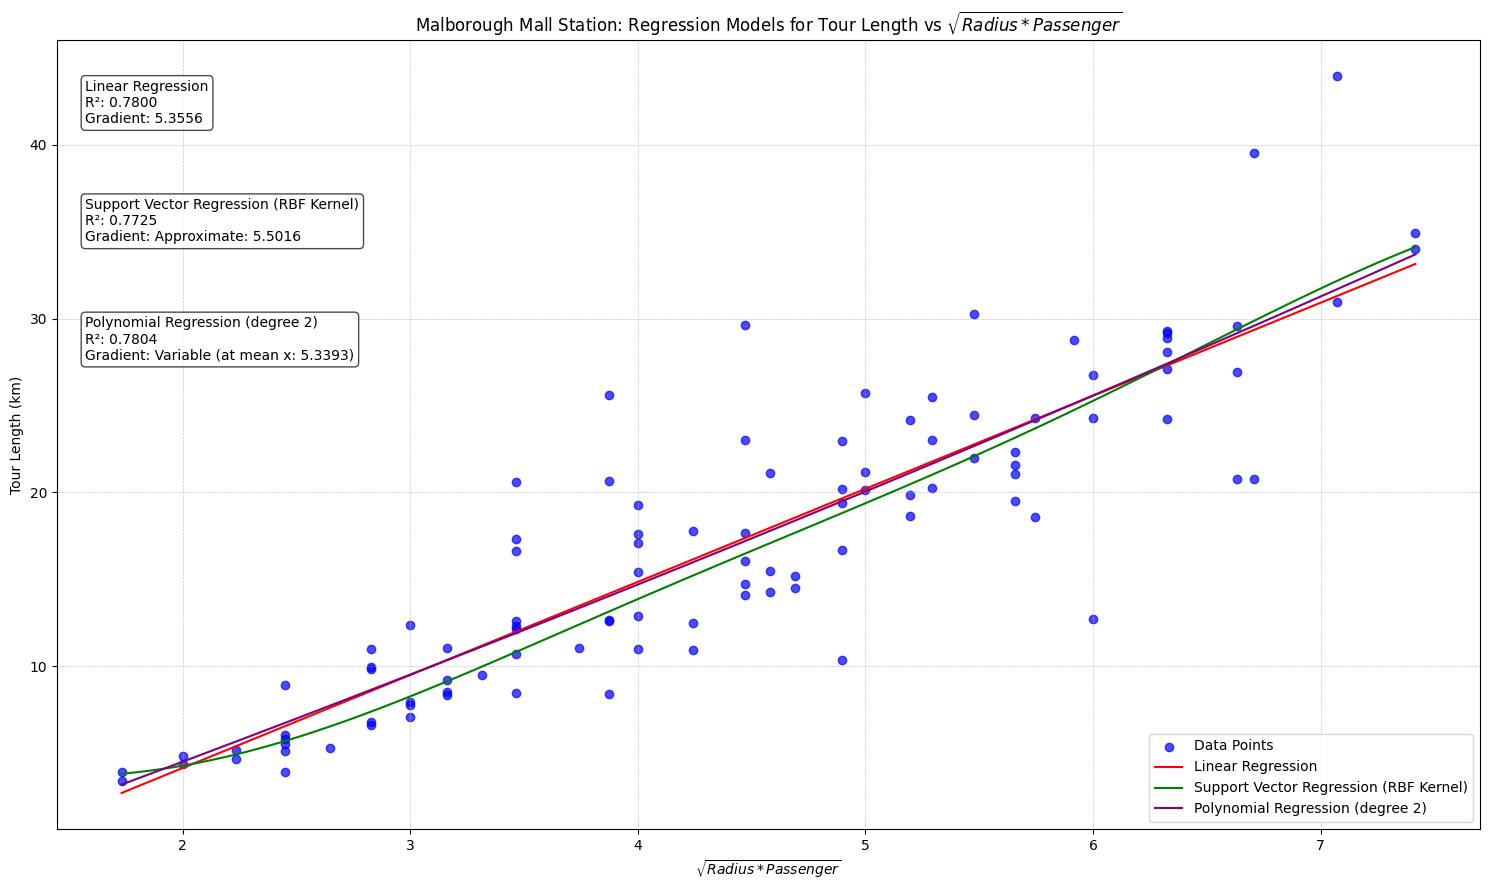


Model Performance and Gradients:
Linear Regression:
R-squared: 0.7800
Gradient: 5.3556
------------------------------
Support Vector Regression (RBF Kernel):
R-squared: 0.7725
Gradient: Approximate: 5.5016
------------------------------
Polynomial Regression (degree 2):
R-squared: 0.7804
Gradient: Variable (at mean x: 5.3393)
------------------------------


In [38]:
# Clean the data - remove rows with empty Tour_Length
df = df.dropna(subset=['Tour_Length'])

# Convert Tour Length to kilometers
df['Tour_Length_km'] = df['Tour_Length'] / 1000

# Calculate sqrt(Radius * Passengers)
df['Sqrt_Radius_Passengers'] = np.sqrt(df['Radius'] * df['Passengers'])

# Prepare data for regression
X = df['Sqrt_Radius_Passengers'].values.reshape(-1, 1)
y = df['Tour_Length_km'].values

# Function to calculate gradient for different models
def calculate_gradient(model, X, name):
    if name == "Polynomial Regression (degree 2)":
        # For polynomial regression, calculate gradient at mean X
        coeffs = model.named_steps['linearregression'].coef_
        intercept = model.named_steps['linearregression'].intercept_
        x_mean = np.mean(X)
        # Quadratic: a*x^2 + b*x + c
        # Gradient is 2ax + b
        gradient = 2 * coeffs[2] * x_mean + coeffs[1]
        return f"Variable (at mean x: {gradient:.4f})"
    
    elif name == "Support Vector Regression (RBF Kernel)":
        # For SVR, estimate gradient by predicting at points near mean
        x_mean = np.mean(X)
        x_sample = np.array([x_mean - 0.1, x_mean, x_mean + 0.1]).reshape(-1, 1)
        y_sample = model.predict(x_sample)
        # Calculate average gradient
        gradient = np.polyfit(x_sample.flatten(), y_sample, 1)[0]
        return f"Approximate: {gradient:.4f}"
    
    elif name == "Linear Regression":
        # For linear regression, use the coefficient directly
        return f"{model.coef_[0]:.4f}"
    
    return "Not calculable"

# Regression Models
models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression (RBF Kernel)": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    "Polynomial Regression (degree 2)": make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
}

# Plot setup
plt.figure(figsize=(15, 9))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.scatter(df['Sqrt_Radius_Passengers'], df['Tour_Length_km'], alpha=0.7, label='Data Points', color='blue')

# Fit and plot for each model
x_fit = np.linspace(df['Sqrt_Radius_Passengers'].min(), df['Sqrt_Radius_Passengers'].max(), 100).reshape(-1, 1)
colors = ['red', 'green', 'purple']
model_stats = {}

for (name, model), color in zip(models.items(), colors):
    model.fit(X, y)
    y_pred = model.predict(x_fit)
    plt.plot(x_fit, y_pred, label=name, color=color)
    
    # Calculate model statistics
    r_squared = model.score(X, y)
    gradient = calculate_gradient(model, X, name)
    
    model_stats[name] = {
        'R-squared': r_squared,
        'Gradient': gradient
    }

# Annotate statistics on the plot
y_max = df['Tour_Length_km'].max()
for i, (name, stats) in enumerate(model_stats.items()):
    annotation_text = (
        f"{name}\n"
        f"R²: {stats['R-squared']:.4f}\n"
        f"Gradient: {stats['Gradient']}"
    )
    plt.annotate(
        annotation_text, 
        xy=(0.02, 0.95 - i*0.15),  # Vertical spacing
        xycoords='axes fraction',
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
    )

# Annotate the plot
plt.xlabel(r'$\sqrt{Radius * Passenger}$')
plt.ylabel('Tour Length (km)')
plt.title("Malborough Mall Station: Regression Models for Tour Length vs $\sqrt{Radius * Passenger}$")
plt.legend()
plt.tight_layout()
plt.show()

# Print additional insights (optional)
print("\nModel Performance and Gradients:")
for name, stats in model_stats.items():
    print(f"{name}:")
    print(f"R-squared: {stats['R-squared']:.4f}")
    print(f"Gradient: {stats['Gradient']}")
    print("-" * 30)

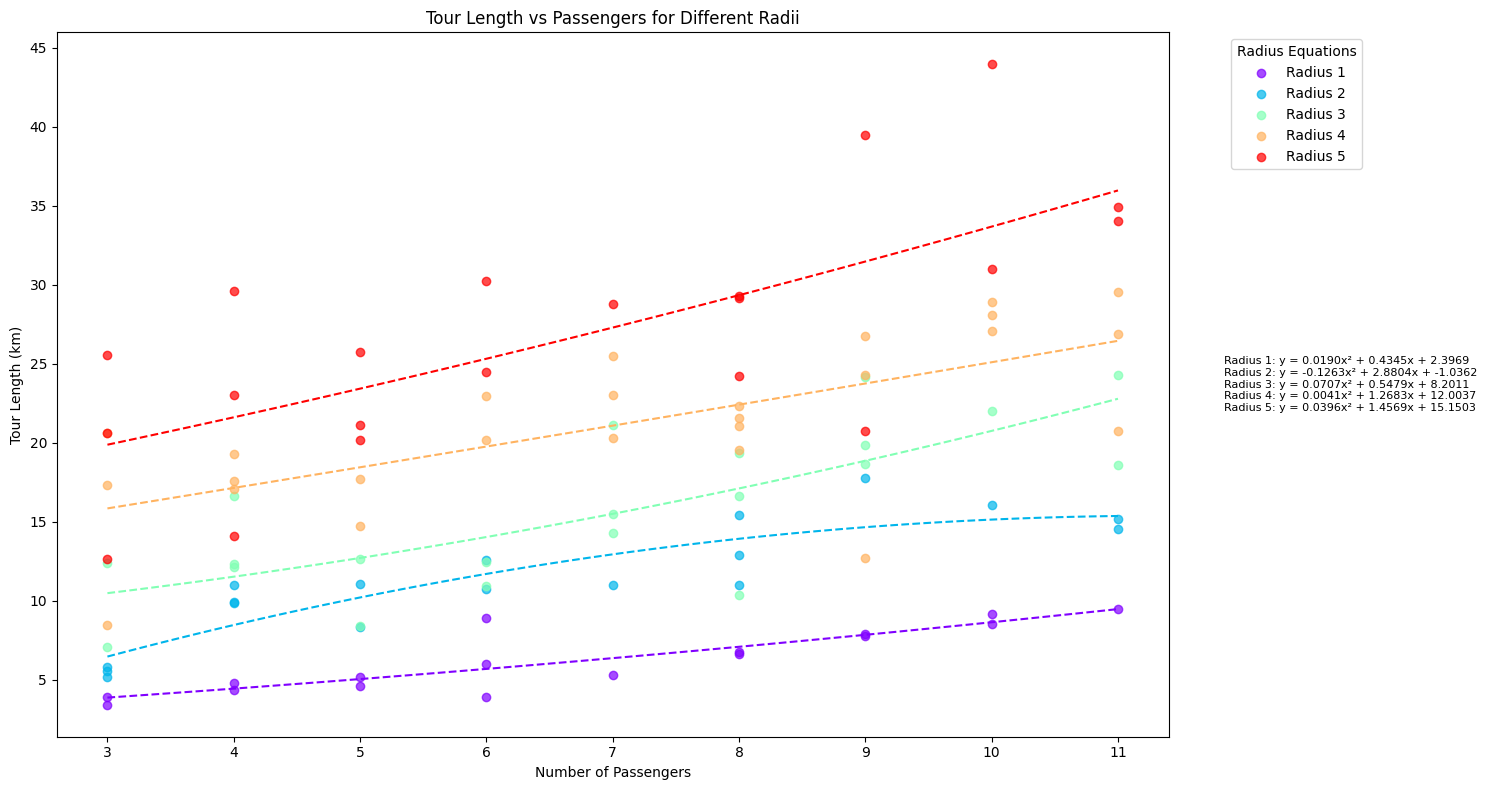

Radius Line Equations:
Radius 1: y = 0.0190x² + 0.4345x + 2.3969
Radius 2: y = -0.1263x² + 2.8804x + -1.0362
Radius 3: y = 0.0707x² + 0.5479x + 8.2011
Radius 4: y = 0.0041x² + 1.2683x + 12.0037
Radius 5: y = 0.0396x² + 1.4569x + 15.1503


In [39]:
# Read the CSV data
# df = pd.read_csv('trip_data_campus_fishcreek2.csv')

# # Clean the data - remove rows with empty Tour_Length
# df = df.dropna(subset=['Tour_Length'])

# # Convert Tour Length to kilometers
# df['Tour_Length_km'] = df['Tour_Length'] / 1000

# Create the plot
plt.figure(figsize=(15, 8))

# Define curve fitting function
def polynomial_fit(x, a, b, c):
    return a * x**2 + b * x + c

# Get unique radii
unique_radii = sorted(df['Radius'].unique())

# Color palette
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_radii)))

# Prepare to store equations
equations = []

# Plot each radius
for radius, color in zip(unique_radii, colors):
    # Filter data for this radius
    radius_df = df[df['Radius'] == radius]
    
    # Scatter plot for this radius
    plt.scatter(radius_df['Passengers'], radius_df['Tour_Length_km'], 
                color=color, label=f'Radius {radius}', alpha=0.7)
    
    # Fit curve for this radius
    if len(radius_df) > 3:  # Ensure enough points for curve fitting
        try:
            popt, _ = curve_fit(polynomial_fit, radius_df['Passengers'], radius_df['Tour_Length_km'])
            
            # Store the equation
            a, b, c = popt
            equation = f'y = {a:.4f}x² + {b:.4f}x + {c:.4f}'
            equations.append(f'Radius {radius}: {equation}')
            
            # Plot the curve
            x_fit = np.linspace(radius_df['Passengers'].min(), radius_df['Passengers'].max(), 100)
            y_fit = polynomial_fit(x_fit, *popt)
            plt.plot(x_fit, y_fit, color=color, linestyle='--')
        except Exception as e:
            print(f"Could not fit curve for Radius {radius}: {e}")

plt.xlabel('Number of Passengers')
plt.ylabel('Tour Length (km)')
plt.title('Tour Length vs Passengers for Different Radii')

# Create legend with equations
plt.legend(title='Radius Equations', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add equations as text
plt.text(1.05, 0.5, '\n'.join(equations), transform=plt.gca().transAxes, 
         verticalalignment='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print equations for reference
print("Radius Line Equations:")
for eq in equations:
    print(eq)

# Turn this into a classifcation problem instead of regression. Instead of predicting tour length exactly, we can predict the class of tour length
# GOOD FOR PAPER
# plot confusion matrix

### North Pointe

In [34]:
df = north_df
print(df)

    Park_and_Ride_Station  Passengers  Radius  Tour_Length
853          North Pointe           3       1     6881.062
854          North Pointe           3       1     7797.946
855          North Pointe           3       2    10759.447
856          North Pointe           3       2    12946.547
857          North Pointe           3       2    10110.224
..                    ...         ...     ...          ...
982          North Pointe          11       4    29272.090
983          North Pointe          11       4    24859.345
984          North Pointe          11       5    29889.405
985          North Pointe          11       5    52013.966
986          North Pointe          11       5    47161.113

[112 rows x 4 columns]


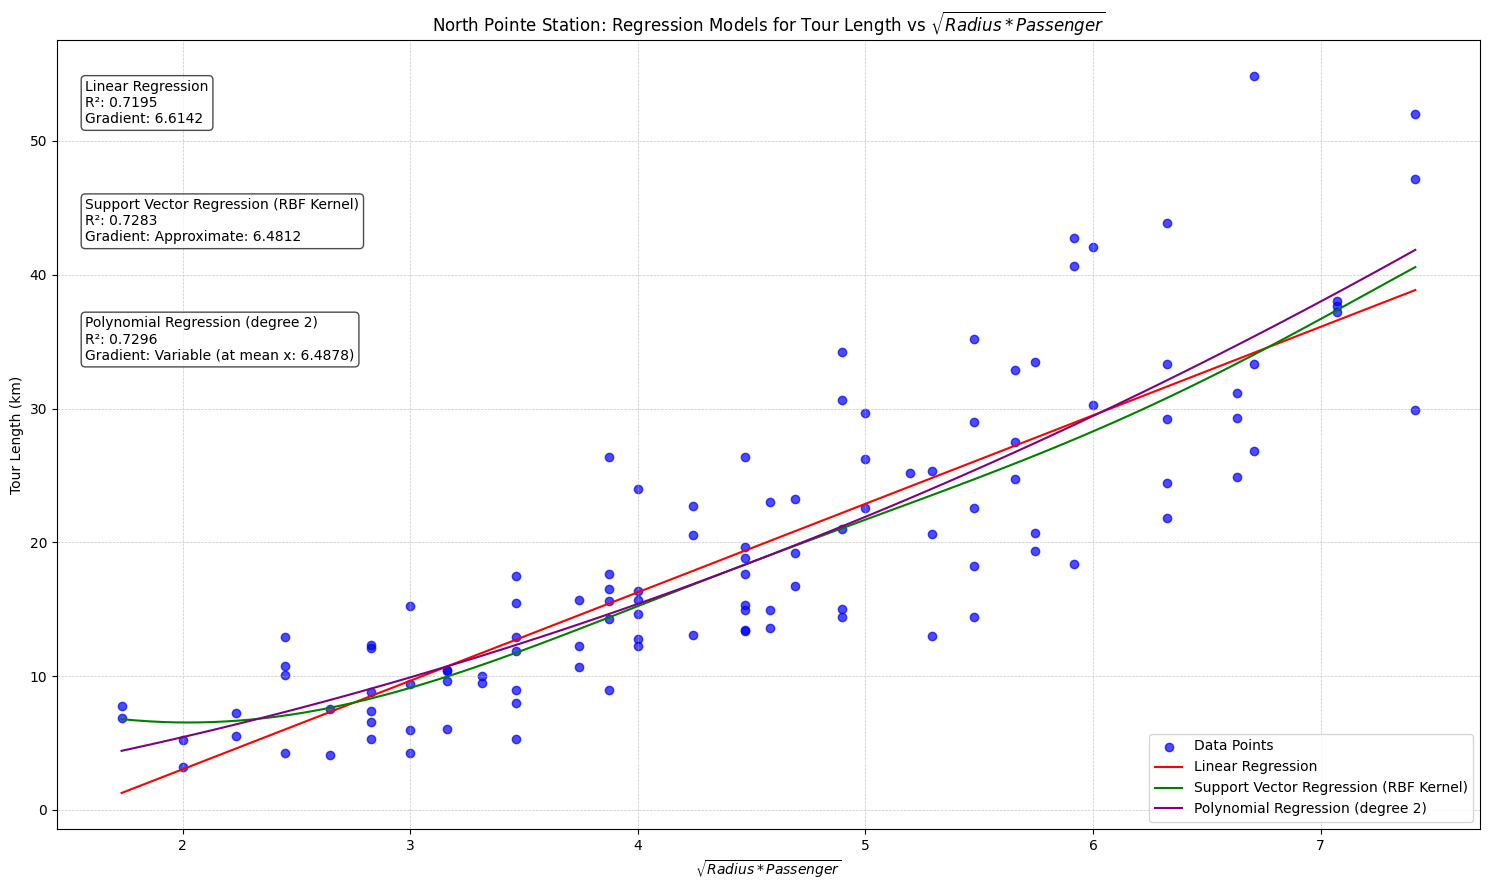


Model Performance and Gradients:
Linear Regression:
R-squared: 0.7195
Gradient: 6.6142
------------------------------
Support Vector Regression (RBF Kernel):
R-squared: 0.7283
Gradient: Approximate: 6.4812
------------------------------
Polynomial Regression (degree 2):
R-squared: 0.7296
Gradient: Variable (at mean x: 6.4878)
------------------------------


In [35]:
# Clean the data - remove rows with empty Tour_Length
df = df.dropna(subset=['Tour_Length'])

# Convert Tour Length to kilometers
df['Tour_Length_km'] = df['Tour_Length'] / 1000

# Calculate sqrt(Radius * Passengers)
df['Sqrt_Radius_Passengers'] = np.sqrt(df['Radius'] * df['Passengers'])

# Prepare data for regression
X = df['Sqrt_Radius_Passengers'].values.reshape(-1, 1)
y = df['Tour_Length_km'].values

# Function to calculate gradient for different models
def calculate_gradient(model, X, name):
    if name == "Polynomial Regression (degree 2)":
        # For polynomial regression, calculate gradient at mean X
        coeffs = model.named_steps['linearregression'].coef_
        intercept = model.named_steps['linearregression'].intercept_
        x_mean = np.mean(X)
        # Quadratic: a*x^2 + b*x + c
        # Gradient is 2ax + b
        gradient = 2 * coeffs[2] * x_mean + coeffs[1]
        return f"Variable (at mean x: {gradient:.4f})"
    
    elif name == "Support Vector Regression (RBF Kernel)":
        # For SVR, estimate gradient by predicting at points near mean
        x_mean = np.mean(X)
        x_sample = np.array([x_mean - 0.1, x_mean, x_mean + 0.1]).reshape(-1, 1)
        y_sample = model.predict(x_sample)
        # Calculate average gradient
        gradient = np.polyfit(x_sample.flatten(), y_sample, 1)[0]
        return f"Approximate: {gradient:.4f}"
    
    elif name == "Linear Regression":
        # For linear regression, use the coefficient directly
        return f"{model.coef_[0]:.4f}"
    
    return "Not calculable"

# Regression Models
models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression (RBF Kernel)": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    "Polynomial Regression (degree 2)": make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
}

# Plot setup
plt.figure(figsize=(15, 9))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.scatter(df['Sqrt_Radius_Passengers'], df['Tour_Length_km'], alpha=0.7, label='Data Points', color='blue')

# Fit and plot for each model
x_fit = np.linspace(df['Sqrt_Radius_Passengers'].min(), df['Sqrt_Radius_Passengers'].max(), 100).reshape(-1, 1)
colors = ['red', 'green', 'purple']
model_stats = {}

for (name, model), color in zip(models.items(), colors):
    model.fit(X, y)
    y_pred = model.predict(x_fit)
    plt.plot(x_fit, y_pred, label=name, color=color)
    
    # Calculate model statistics
    r_squared = model.score(X, y)
    gradient = calculate_gradient(model, X, name)
    
    model_stats[name] = {
        'R-squared': r_squared,
        'Gradient': gradient
    }

# Annotate statistics on the plot
y_max = df['Tour_Length_km'].max()
for i, (name, stats) in enumerate(model_stats.items()):
    annotation_text = (
        f"{name}\n"
        f"R²: {stats['R-squared']:.4f}\n"
        f"Gradient: {stats['Gradient']}"
    )
    plt.annotate(
        annotation_text, 
        xy=(0.02, 0.95 - i*0.15),  # Vertical spacing
        xycoords='axes fraction',
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
    )

# Annotate the plot
plt.xlabel(r'$\sqrt{Radius * Passenger}$')
plt.ylabel('Tour Length (km)')
plt.title("North Pointe Station: Regression Models for Tour Length vs $\sqrt{Radius * Passenger}$")
plt.legend()
plt.tight_layout()
plt.show()

# Print additional insights (optional)
print("\nModel Performance and Gradients:")
for name, stats in model_stats.items():
    print(f"{name}:")
    print(f"R-squared: {stats['R-squared']:.4f}")
    print(f"Gradient: {stats['Gradient']}")
    print("-" * 30)

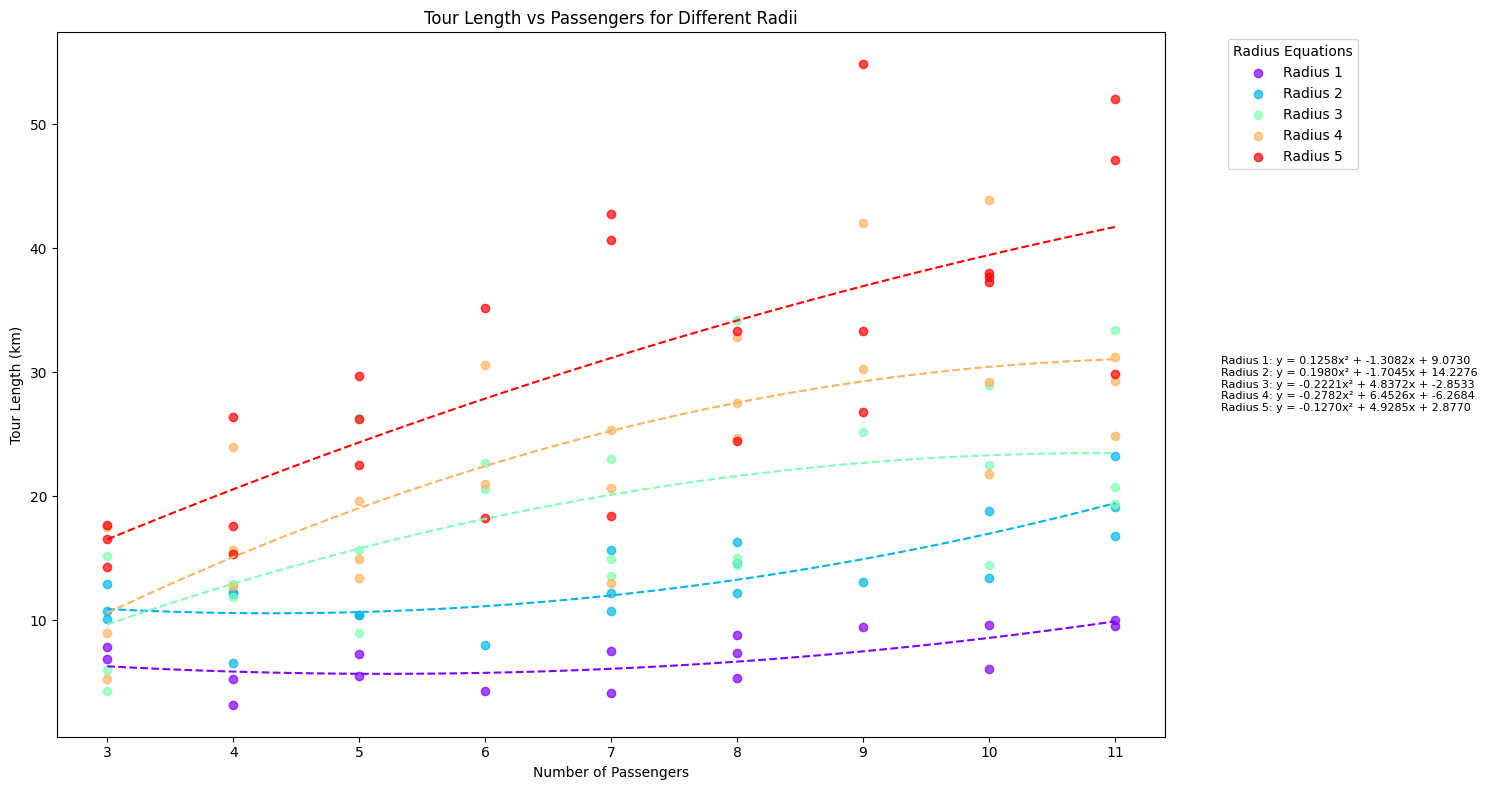

Radius Line Equations:
Radius 1: y = 0.1258x² + -1.3082x + 9.0730
Radius 2: y = 0.1980x² + -1.7045x + 14.2276
Radius 3: y = -0.2221x² + 4.8372x + -2.8533
Radius 4: y = -0.2782x² + 6.4526x + -6.2684
Radius 5: y = -0.1270x² + 4.9285x + 2.8770


In [36]:
# Read the CSV data
# df = pd.read_csv('trip_data_campus_fishcreek2.csv')

# # Clean the data - remove rows with empty Tour_Length
# df = df.dropna(subset=['Tour_Length'])

# # Convert Tour Length to kilometers
# df['Tour_Length_km'] = df['Tour_Length'] / 1000

# Create the plot
plt.figure(figsize=(15, 8))

# Define curve fitting function
def polynomial_fit(x, a, b, c):
    return a * x**2 + b * x + c

# Get unique radii
unique_radii = sorted(df['Radius'].unique())

# Color palette
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_radii)))

# Prepare to store equations
equations = []

# Plot each radius
for radius, color in zip(unique_radii, colors):
    # Filter data for this radius
    radius_df = df[df['Radius'] == radius]
    
    # Scatter plot for this radius
    plt.scatter(radius_df['Passengers'], radius_df['Tour_Length_km'], 
                color=color, label=f'Radius {radius}', alpha=0.7)
    
    # Fit curve for this radius
    if len(radius_df) > 3:  # Ensure enough points for curve fitting
        try:
            popt, _ = curve_fit(polynomial_fit, radius_df['Passengers'], radius_df['Tour_Length_km'])
            
            # Store the equation
            a, b, c = popt
            equation = f'y = {a:.4f}x² + {b:.4f}x + {c:.4f}'
            equations.append(f'Radius {radius}: {equation}')
            
            # Plot the curve
            x_fit = np.linspace(radius_df['Passengers'].min(), radius_df['Passengers'].max(), 100)
            y_fit = polynomial_fit(x_fit, *popt)
            plt.plot(x_fit, y_fit, color=color, linestyle='--')
        except Exception as e:
            print(f"Could not fit curve for Radius {radius}: {e}")

plt.xlabel('Number of Passengers')
plt.ylabel('Tour Length (km)')
plt.title('Tour Length vs Passengers for Different Radii')

# Create legend with equations
plt.legend(title='Radius Equations', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add equations as text
plt.text(1.05, 0.5, '\n'.join(equations), transform=plt.gca().transAxes, 
         verticalalignment='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print equations for reference
print("Radius Line Equations:")
for eq in equations:
    print(eq)

# Turn this into a classifcation problem instead of regression. Instead of predicting tour length exactly, we can predict the class of tour length
# GOOD FOR PAPER
# plot confusion matrix

## Calgary as whole

In [25]:
df = pd.read_csv('trip_data_campus_full.csv')
df = df.dropna(subset=['Tour_Length'])
print(df.head())

                 Park_and_Ride_Station  Passengers  Radius  Tour_Length
0  Fish Creek - Lacombe CTrain Station           4       2     8644.316
1  Fish Creek - Lacombe CTrain Station           4       2     8790.838
2  Fish Creek - Lacombe CTrain Station           4       2    10323.515
3  Fish Creek - Lacombe CTrain Station           4       3     9205.104
4  Fish Creek - Lacombe CTrain Station           4       3    13306.332


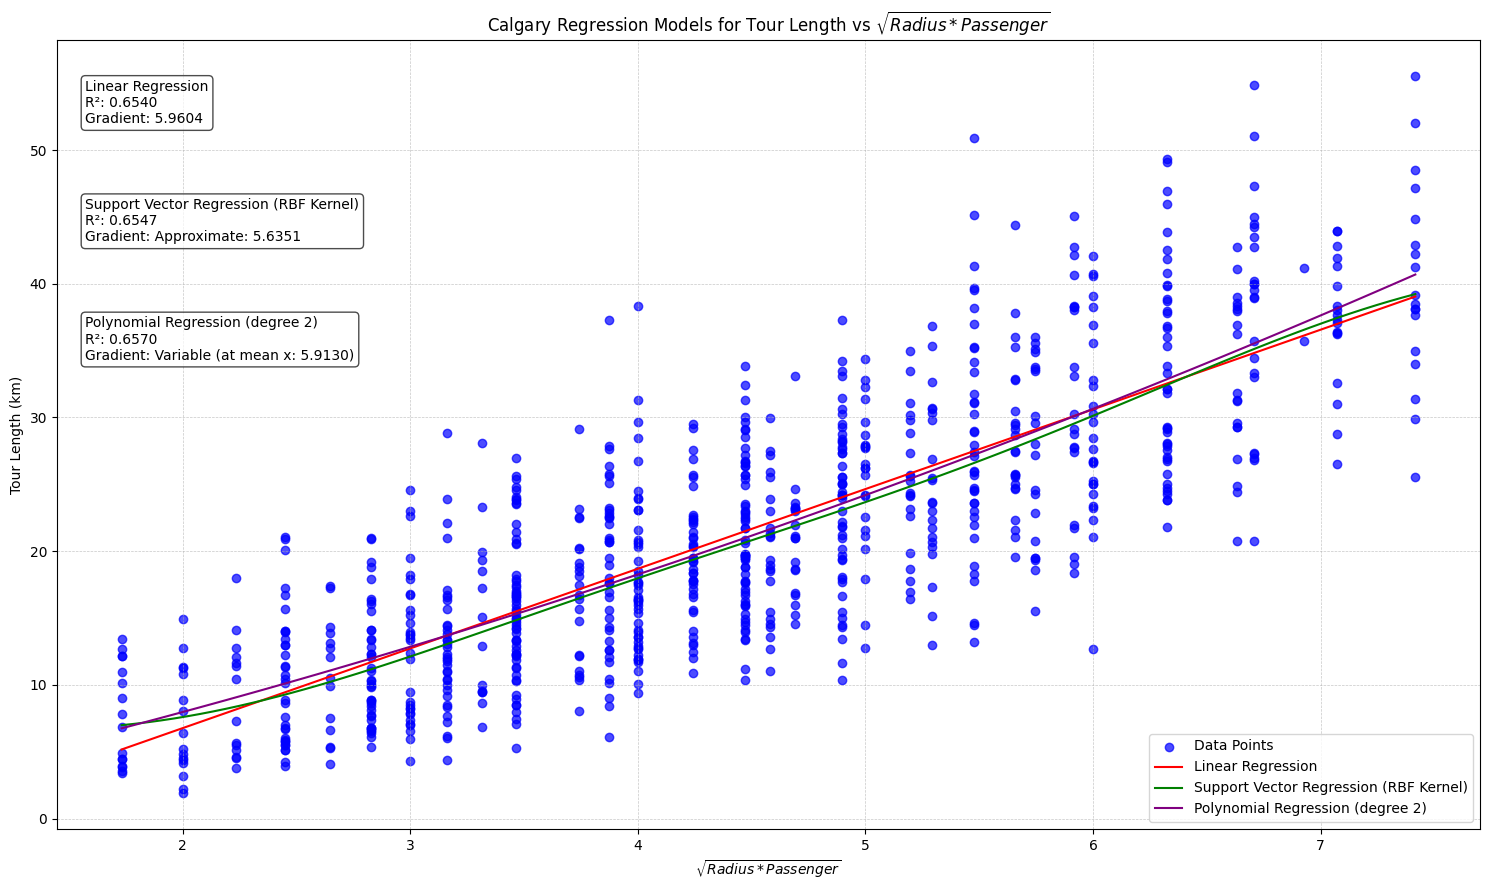


Model Performance and Gradients:
Linear Regression:
R-squared: 0.6540
Gradient: 5.9604
------------------------------
Support Vector Regression (RBF Kernel):
R-squared: 0.6547
Gradient: Approximate: 5.6351
------------------------------
Polynomial Regression (degree 2):
R-squared: 0.6570
Gradient: Variable (at mean x: 5.9130)
------------------------------


In [26]:
# Clean the data - remove rows with empty Tour_Length
df = df.dropna(subset=['Tour_Length'])

# Convert Tour Length to kilometers
df['Tour_Length_km'] = df['Tour_Length'] / 1000

# Calculate sqrt(Radius * Passengers)
df['Sqrt_Radius_Passengers'] = np.sqrt(df['Radius'] * df['Passengers'])

# Prepare data for regression
X = df['Sqrt_Radius_Passengers'].values.reshape(-1, 1)
y = df['Tour_Length_km'].values

# Function to calculate gradient for different models
def calculate_gradient(model, X, name):
    if name == "Polynomial Regression (degree 2)":
        # For polynomial regression, calculate gradient at mean X
        coeffs = model.named_steps['linearregression'].coef_
        intercept = model.named_steps['linearregression'].intercept_
        x_mean = np.mean(X)
        # Quadratic: a*x^2 + b*x + c
        # Gradient is 2ax + b
        gradient = 2 * coeffs[2] * x_mean + coeffs[1]
        return f"Variable (at mean x: {gradient:.4f})"
    
    elif name == "Support Vector Regression (RBF Kernel)":
        # For SVR, estimate gradient by predicting at points near mean
        x_mean = np.mean(X)
        x_sample = np.array([x_mean - 0.1, x_mean, x_mean + 0.1]).reshape(-1, 1)
        y_sample = model.predict(x_sample)
        # Calculate average gradient
        gradient = np.polyfit(x_sample.flatten(), y_sample, 1)[0]
        return f"Approximate: {gradient:.4f}"
    
    elif name == "Linear Regression":
        # For linear regression, use the coefficient directly
        return f"{model.coef_[0]:.4f}"
    
    return "Not calculable"

# Regression Models
models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression (RBF Kernel)": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    "Polynomial Regression (degree 2)": make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
}

# Plot setup
plt.figure(figsize=(15, 9))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.scatter(df['Sqrt_Radius_Passengers'], df['Tour_Length_km'], alpha=0.7, label='Data Points', color='blue')

# Fit and plot for each model
x_fit = np.linspace(df['Sqrt_Radius_Passengers'].min(), df['Sqrt_Radius_Passengers'].max(), 100).reshape(-1, 1)
colors = ['red', 'green', 'purple']
model_stats = {}

for (name, model), color in zip(models.items(), colors):
    model.fit(X, y)
    y_pred = model.predict(x_fit)
    plt.plot(x_fit, y_pred, label=name, color=color)
    
    # Calculate model statistics
    r_squared = model.score(X, y)
    gradient = calculate_gradient(model, X, name)
    
    model_stats[name] = {
        'R-squared': r_squared,
        'Gradient': gradient
    }

# Annotate statistics on the plot
y_max = df['Tour_Length_km'].max()
for i, (name, stats) in enumerate(model_stats.items()):
    annotation_text = (
        f"{name}\n"
        f"R²: {stats['R-squared']:.4f}\n"
        f"Gradient: {stats['Gradient']}"
    )
    plt.annotate(
        annotation_text, 
        xy=(0.02, 0.95 - i*0.15),  # Vertical spacing
        xycoords='axes fraction',
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
    )

# Annotate the plot
plt.xlabel(r'$\sqrt{Radius * Passenger}$')
plt.ylabel('Tour Length (km)')
plt.title("Calgary Regression Models for Tour Length vs $\sqrt{Radius * Passenger}$")
plt.legend()
plt.tight_layout()
plt.show()

# Print additional insights (optional)
print("\nModel Performance and Gradients:")
for name, stats in model_stats.items():
    print(f"{name}:")
    print(f"R-squared: {stats['R-squared']:.4f}")
    print(f"Gradient: {stats['Gradient']}")
    print("-" * 30)